# Prelude
Ayt I honestly don't know what to feel about this activity. It's very hard and confusing.

# Acknowledgements
I'd like to thank my instructors, Sir Rene Principe Jr. and Sir Kenneth Leo, for guiding me throughout the activity. I would also like to thank my professor, Ma'am Jing, for guiding me in my coding while my classmates and I worked in R202. I would also like to acknowledge my classmates: Abdel, Johnenn, Jonabel, Richmond, Lovely, Hans, Genesis, Jeruine, Rusher, and Ron for helping me complete this activity.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics as st
import pandas as pd
from sklearn.model_selection import train_test_split

image_repository = "./Image repository/"
data_repository = "./Features extracted/"


> #### ${\tt Model~and~Activation~Functions}$ 
> 1. ${\tt model}$ takes an input of an array $x$ outputs a sine wave with an angular frequency of $2\pi$
> 2. ${\tt sigmoid}$, ${\tt tanh}$, ${\tt linear}$, and ${\tt rectified\_linear}$ are activation functions

In [24]:
def model(x):
    output = np.sin(2*np.pi*x)
    output = (output - np.min(output))/(np.max(output) - np.min(output))
    output = np.reshape(output, (len(x), 1))
    return output

def sigmoid(a, derivative = False):
    if derivative == False:
        output = 1/(1 + np.exp(-a))
    else:
        s = sigmoid(a)
        output = s*(1 - s)
    return output

def tanh(a, derivative = False):
    if derivative == False:
        output = np.tanh(a)
    else:
        output = 1 + (np.tanh(a))**2
    return output 

def linear(x, derivative = False):
    if derivative == False:
        output = x
    else:
        output = 1
    return output

def rectified_linear(x, derivative = False):
    if derivative == False:
        output = np.maximum(0,x)
    else:
        output = np.maximum(0,1)
    return output
    

> #### ${\tt Preprocessing~Functions}$ 
> 1. ${\tt x\_vectors}$ takes an input of an array $x$ and outputs a vector of the same length and each element of the vector is $[x^{0}, x^{1}, x^{2}, ..., x^{n}]$.
> 2. ${\tt intialize\_weights\_biases}$ creates weight vectors and biases based on the number of nodes of the input, hidden, and output layers.

In [25]:
def x_vectors(x, n):
    vectors = []
    for i in range(n):
        vectors.append(x**i)
    vecs = np.dstack(np.split(np.array(vectors), n))
    vecs = np.reshape(vecs, (vecs.shape[1], vecs.shape[2]))
    return vecs


def initialize_weights_biases(input_size, hidden_size, output_size, factor = 0.01):
    omega0 = np.random.randn(hidden_size,input_size)*factor
    omega1 = np.random.randn(output_size, hidden_size)*factor
    bias0 = np.ones(hidden_size)
    bias1 = np.ones(output_size)

    weights_biases = {'omega0': omega0, 'omega1': omega1,'bias0': bias0,'bias1': bias1,}
    return weights_biases

# Function prediction

> #### ${\tt start\_learning}$ 
> The learning algorithm for the neural network. The neural network consists of 3 layers (input, hidden, output). The learning process stops after $50,000$ epochs or the RMSE falls below the error threshold (whichever comes first).

In [49]:
def start_learning(x, validation, weights_biases, learning_rate, afunc_hidden, afunc_out, error_threshold, error_tracker = False):
    omega_h = weights_biases['omega0'].copy()
    omega_o = weights_biases['omega1'].copy()
    bias0 = weights_biases['bias0'].copy()
    bias1 = weights_biases['bias1'].copy()
    RMSE = []
    max_epoch = 50000
    epoch_counter = 1
    
    while True:
        # Getting outputs of the hidden layer
        aji = np.dot(x, omega_h.T)
        hidden_layer = afunc_hidden(aji + bias0)
            
        # Getting output 
        ak = np.dot(hidden_layer, omega_o.T) 
        output_layer = afunc_out(ak + bias1)
        
        # RMSE
        error = output_layer - validation 
        current_RMSE = np.sqrt(np.mean(error**2))
        RMSE.append(current_RMSE)
        
        # For debugging
        if error_tracker == True:
            if epoch_counter%100 == 0:
                print('RMSE at epoch', epoch_counter, ': ', current_RMSE)
                
        # Breaks if RMSE is lesser than the threshol or if the maximum number of epochs have been reached
        if current_RMSE < error_threshold:
            break
        elif epoch_counter >= max_epoch:
            break
        
        # Solving for the error of the output
        delta_output = afunc_out((ak + bias1), derivative = True)*error

        # Solving for the error of the hidden units
        delta_hidden = afunc_hidden(aji + bias0, derivative = True)*np.dot(delta_output, omega_o)

        # Solving for the error derivatives
        E_hidden_derivative = np.dot(x.T, delta_hidden).T
        E_output_derivative = np.dot(hidden_layer.T,delta_output).T
        
        # updating weights
        omega_h += -learning_rate*E_hidden_derivative
        omega_o += -learning_rate*E_output_derivative
        
        epoch_counter +=1
    
    return output_layer, np.array(RMSE), omega_h, omega_o



> #### ${\tt create\_plots}$ 
> Create the plots for the function prediction.

In [51]:
def create_plots(x, predictions, validation,  RMSE, input_size, hidden_size, afunc_h, afunc_o, learning_rate, error_threshold):
    epochs = np.arange(1, len(RMSE)+1, 1)
    fig, ax = plt.subplots(1,2, figsize = (15,6))
    ax[0].scatter(x, validation, label = 'validation data', color = 'salmon')
    ax[0].plot(x, predictions, linestyle = '--', lw = 2, color = 'maroon', label = 'neural network prediction')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[0].set_title('Data points: ' + str(len(x)) +
                    '; Input nodes: ' + str(input_size) +
                    '; Hidden nodes: ' + str(hidden_size) +
                    '\nHidden Activation function: ' + str(afunc_h.__name__) +
                    '\nOutput Activation function: ' + str(afunc_o.__name__) +
                    '\nLearning Rate: ' + str(learning_rate),
                    loc = 'left')
    ax[0].legend()

    ax[1].plot(epochs, RMSE, linestyle = '--', marker = 'o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('RMSE')
    
    if RMSE[len(RMSE)-1] >= error_threshold:
        ax[1].set_title('RMSE vs Epochs' +
                    '\nError threshold: ' + str(error_threshold) +
                    '\nTotal epochs: ' + str(len(RMSE))+
                    '\nFinal Error: ' + str(RMSE[len(RMSE)-1])+
                    '\nRemark: Took to long so program stopped.',
                    loc = 'left'
        )
    else:
        ax[1].set_title('RMSE vs Epochs' +
                    '\nError threshold: ' + str(error_threshold) +
                    '\nTotal epochs: ' + str(len(RMSE)),
                    loc = 'left'
        )
    
    plt.tight_layout()
    plt.show()

## Testing my neural network function

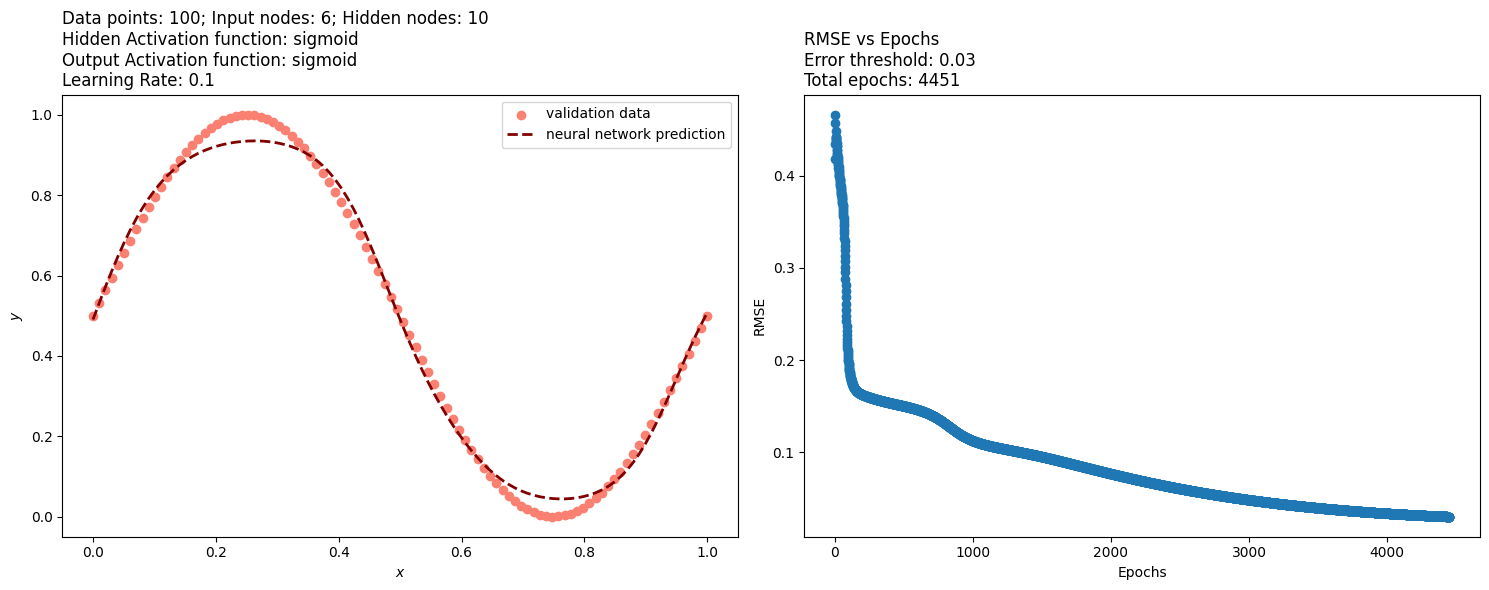

In [28]:
# Setting the parameters
input_size = 6
hidden_size = 10
learning_rate = 0.1
x = np.linspace(0, 1, 100)
x_vec = x_vectors(x, input_size)
error_threshold = 0.03
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= sigmoid
activation_function2= sigmoid
validation = model(x)

# Using the neural network
z, RMSE, omega_h, omega_o = start_learning(x_vec, validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
create_plots(x, z, validation,  RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)

## Now testing different activation functions

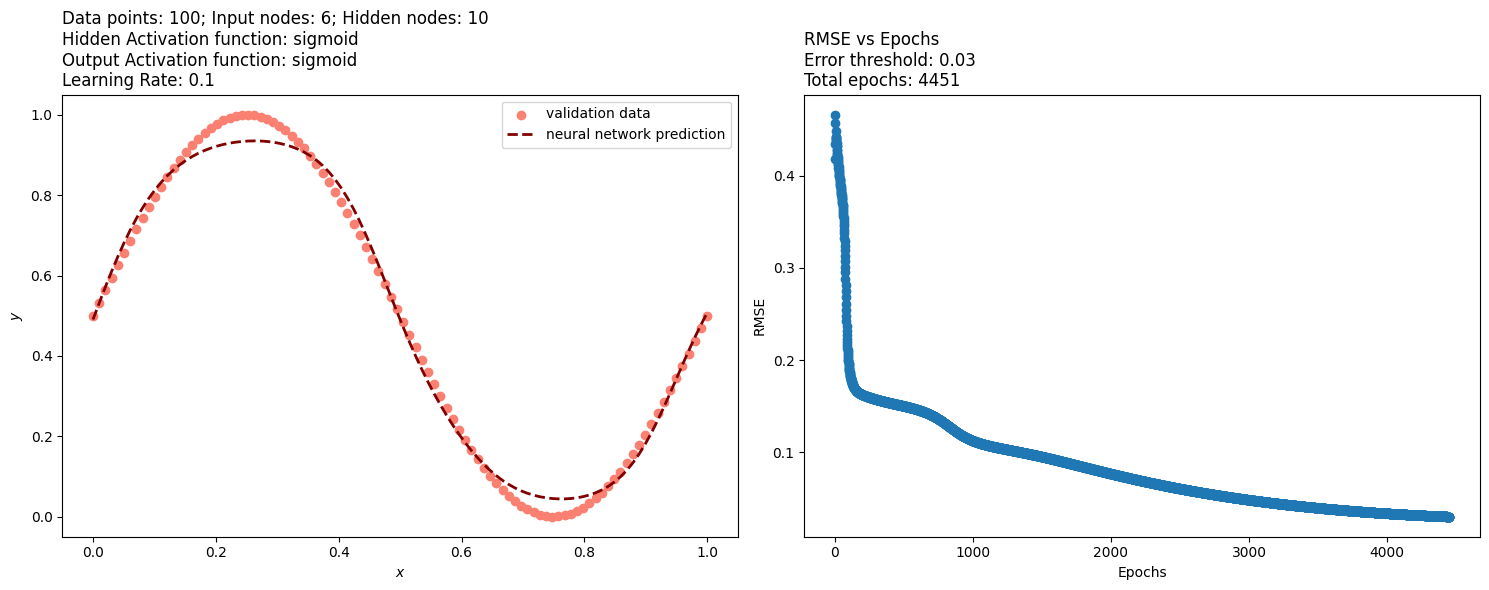

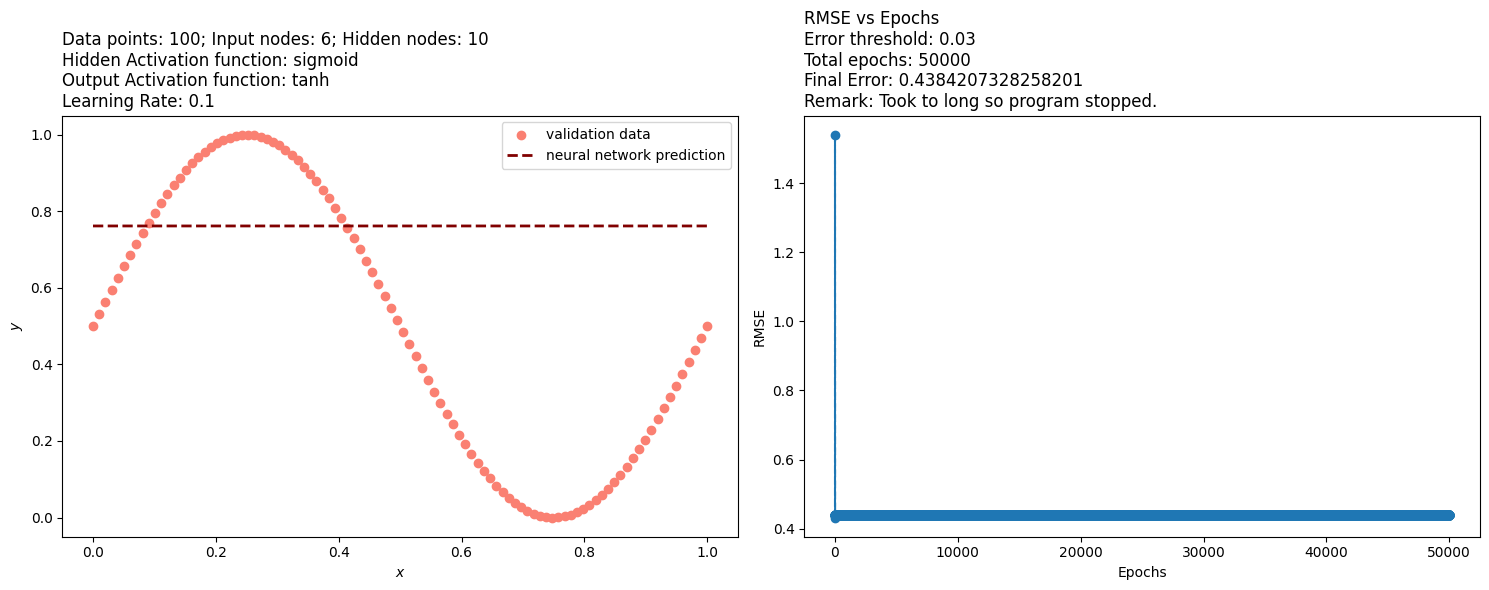

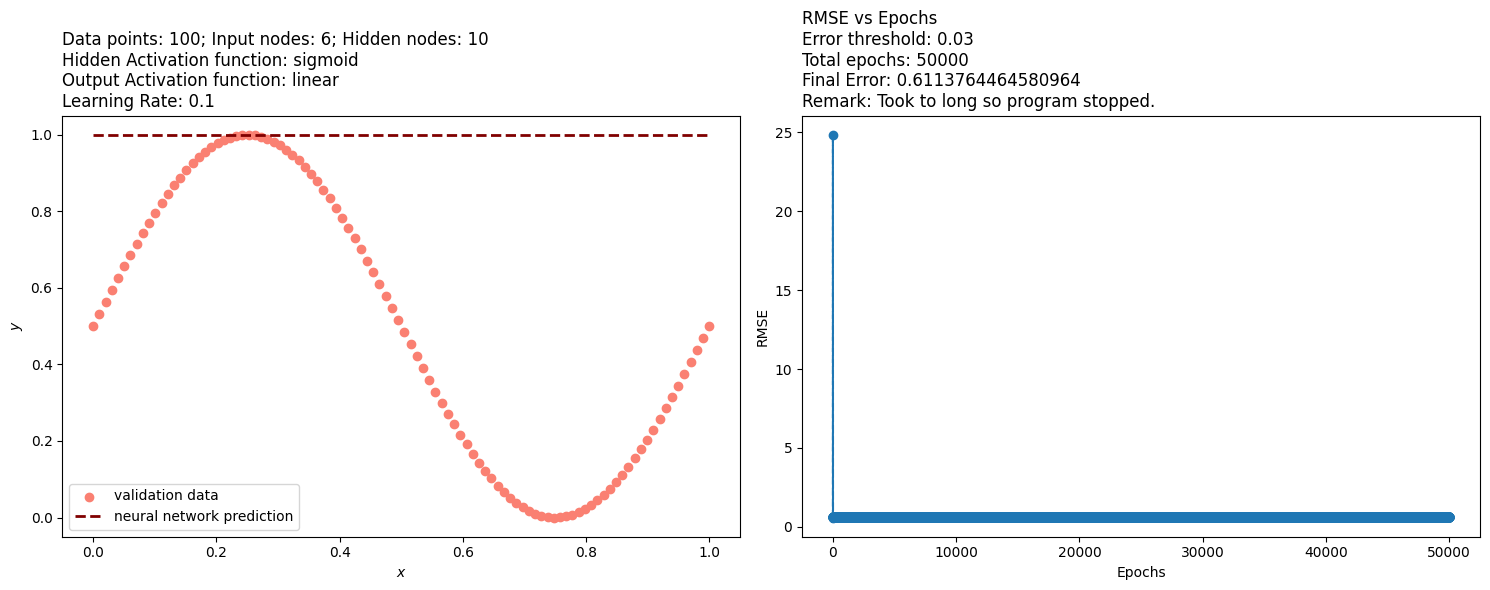

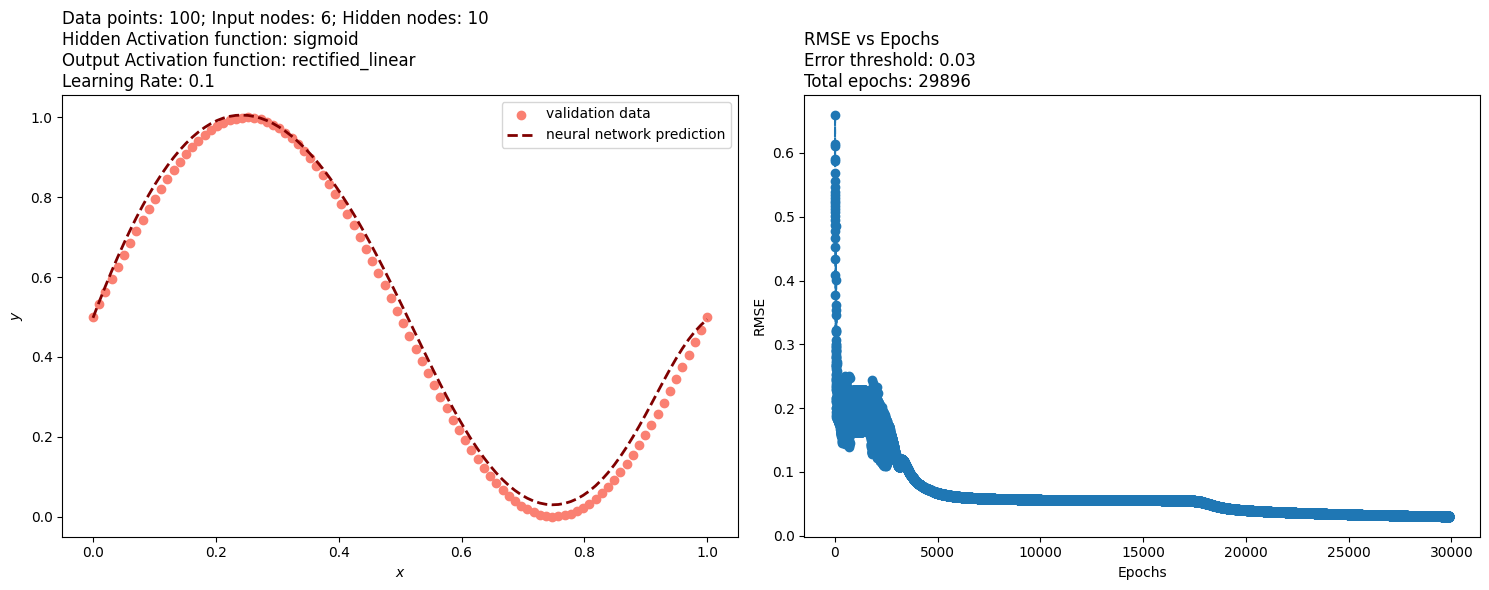

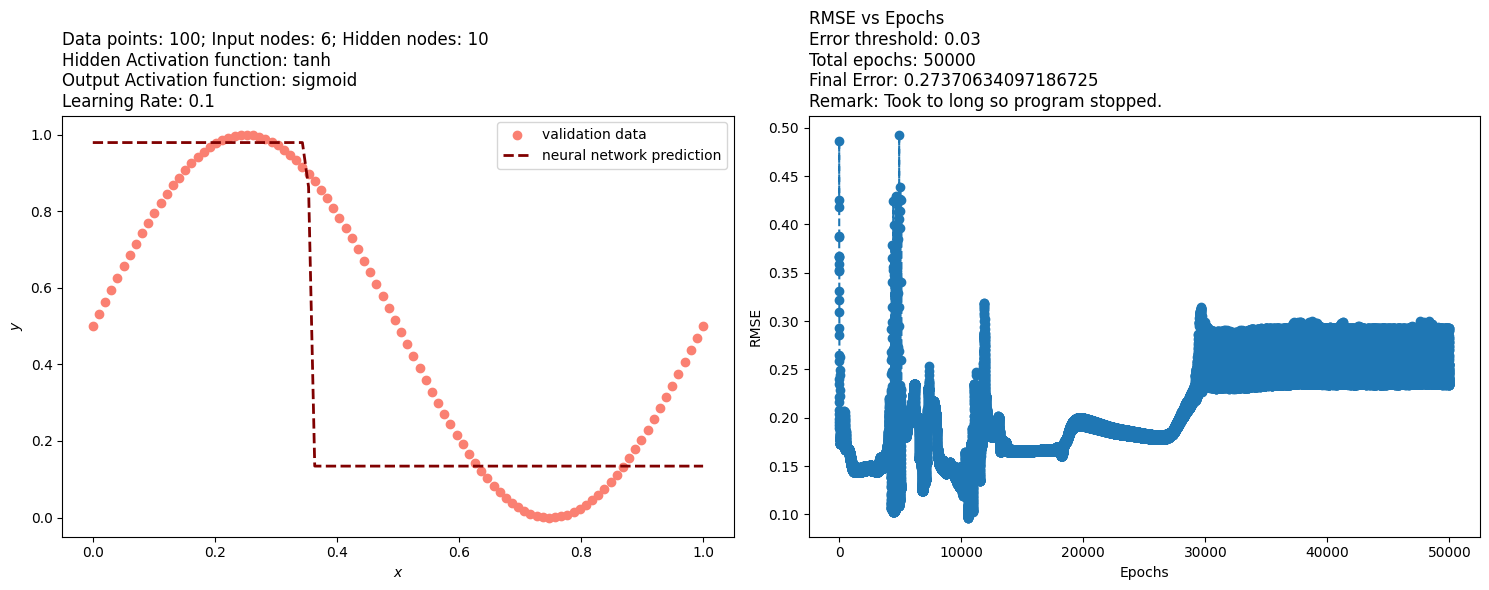

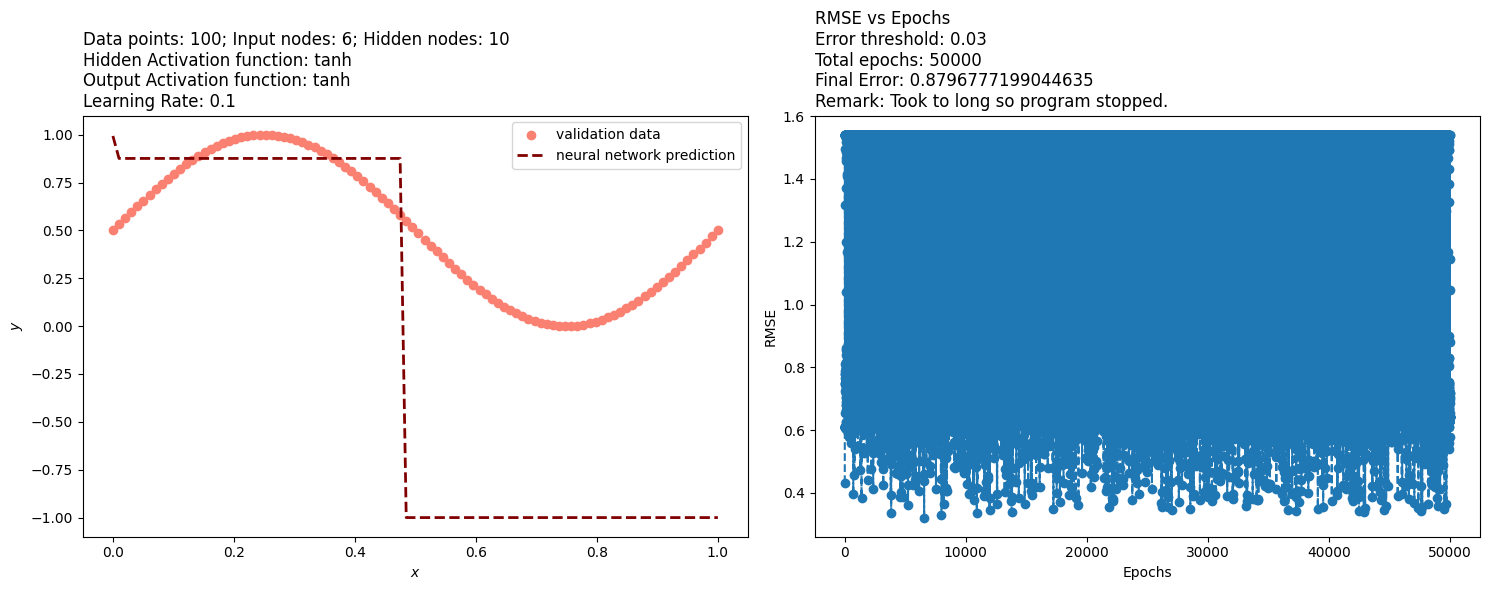

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10288\3404412489.py:21: RuntimeWarning: overflow encountered in square
  current_RMSE = np.sqrt(np.mean(error**2))


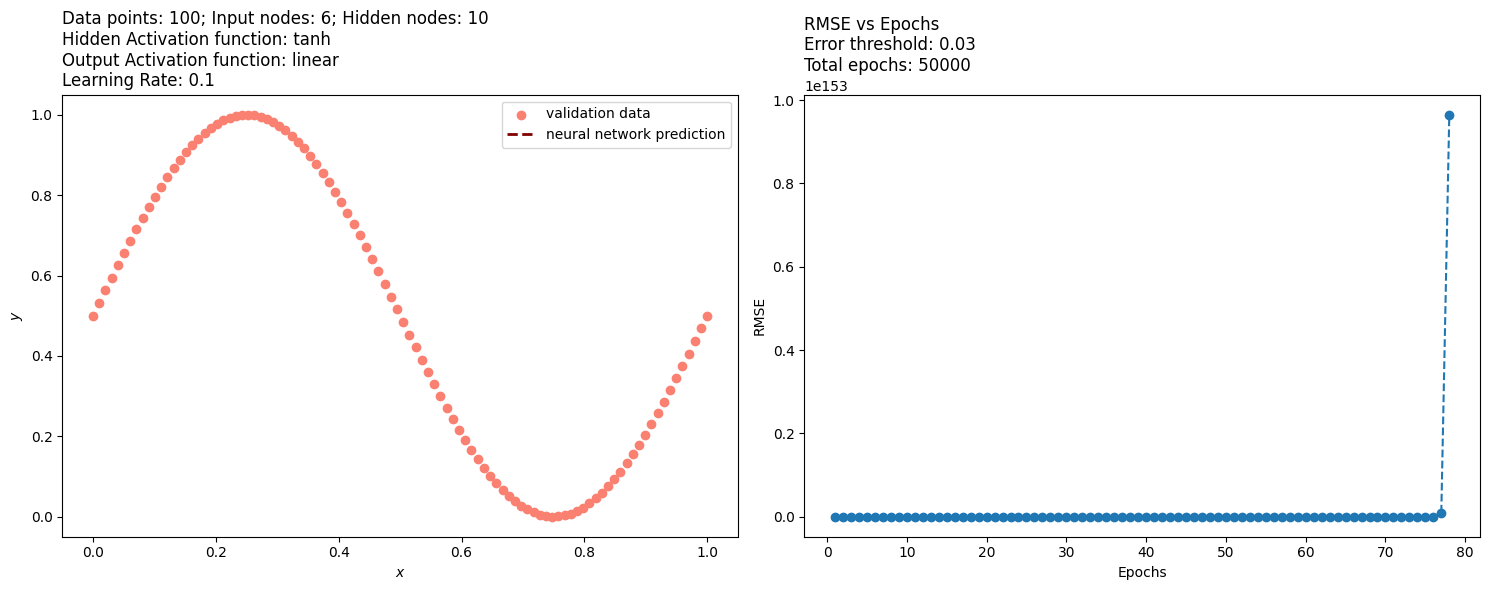

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


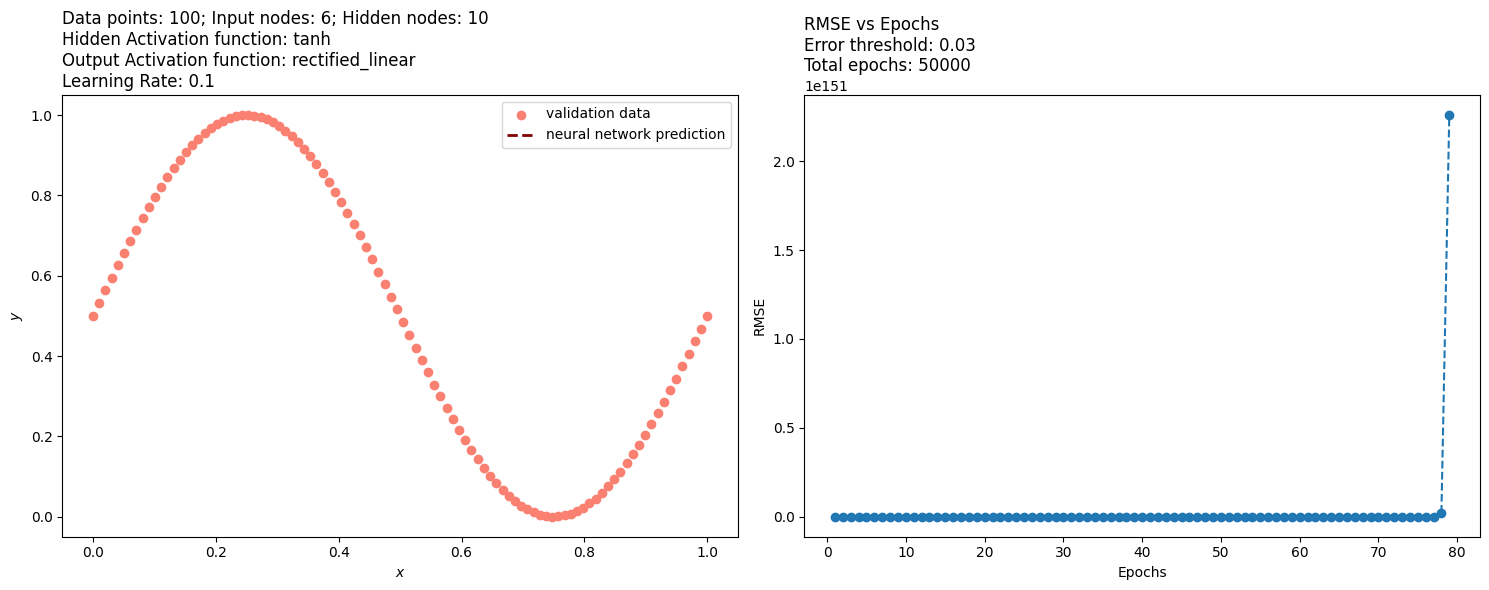

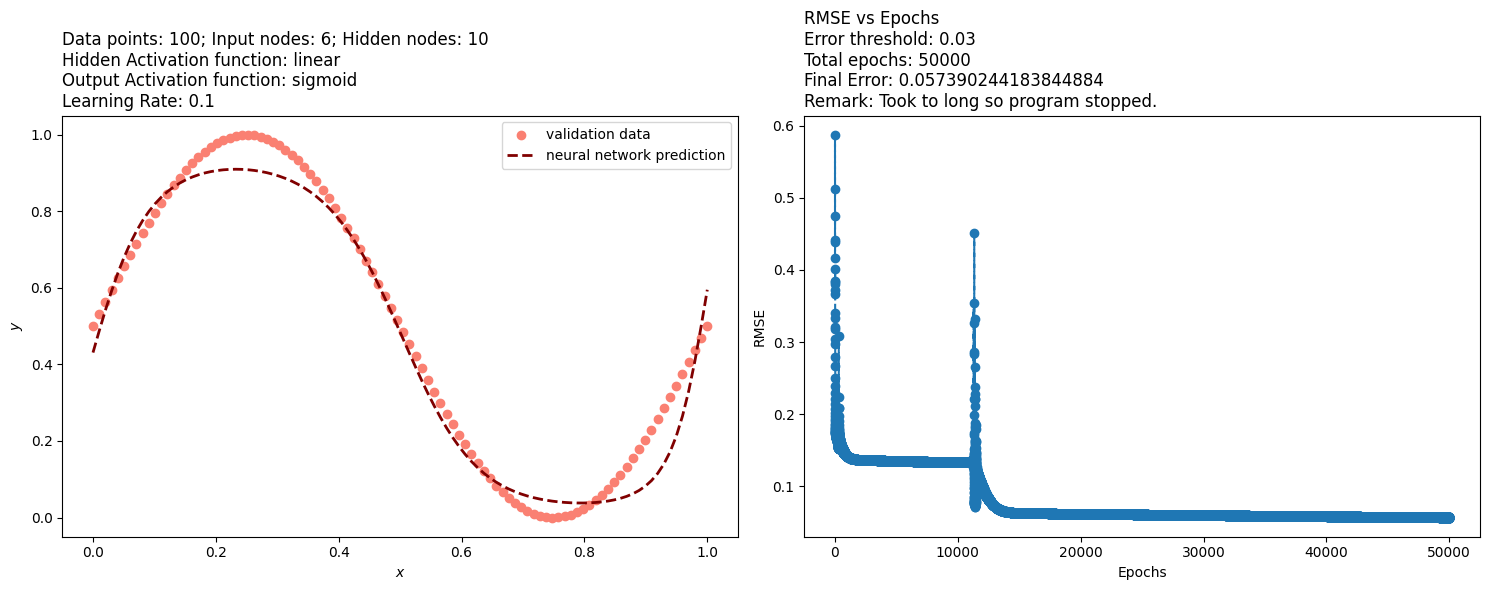

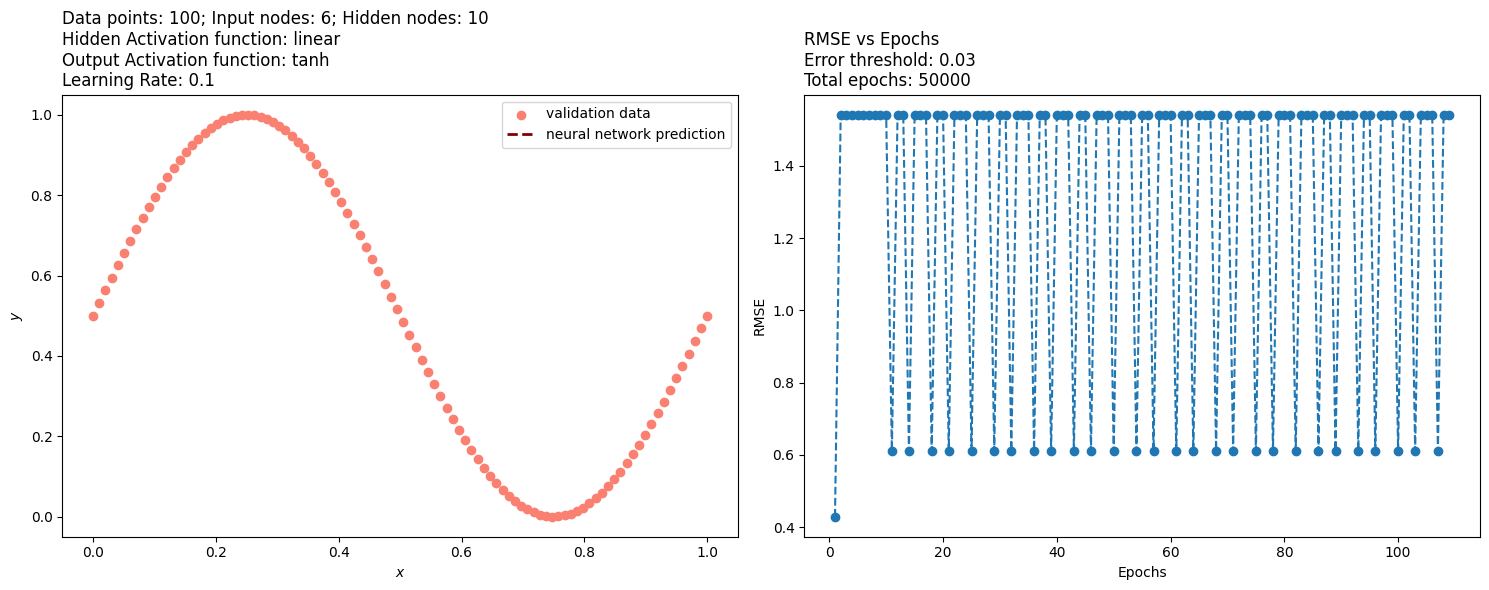

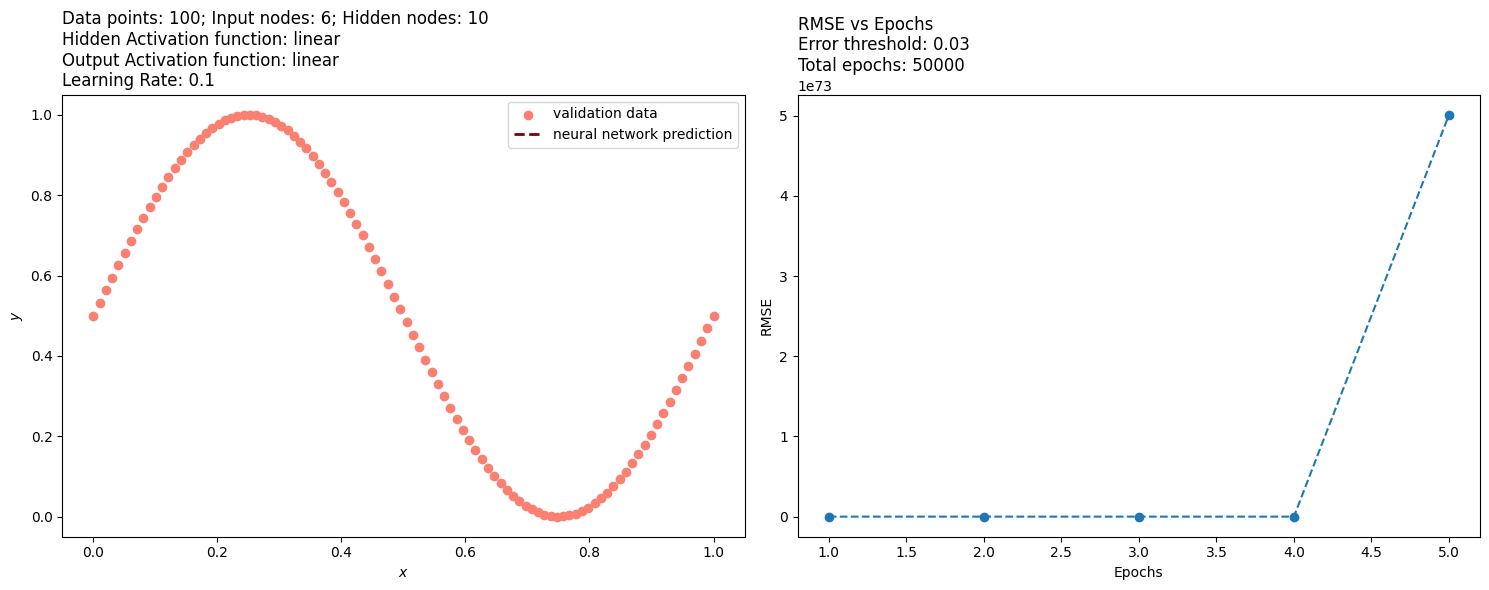

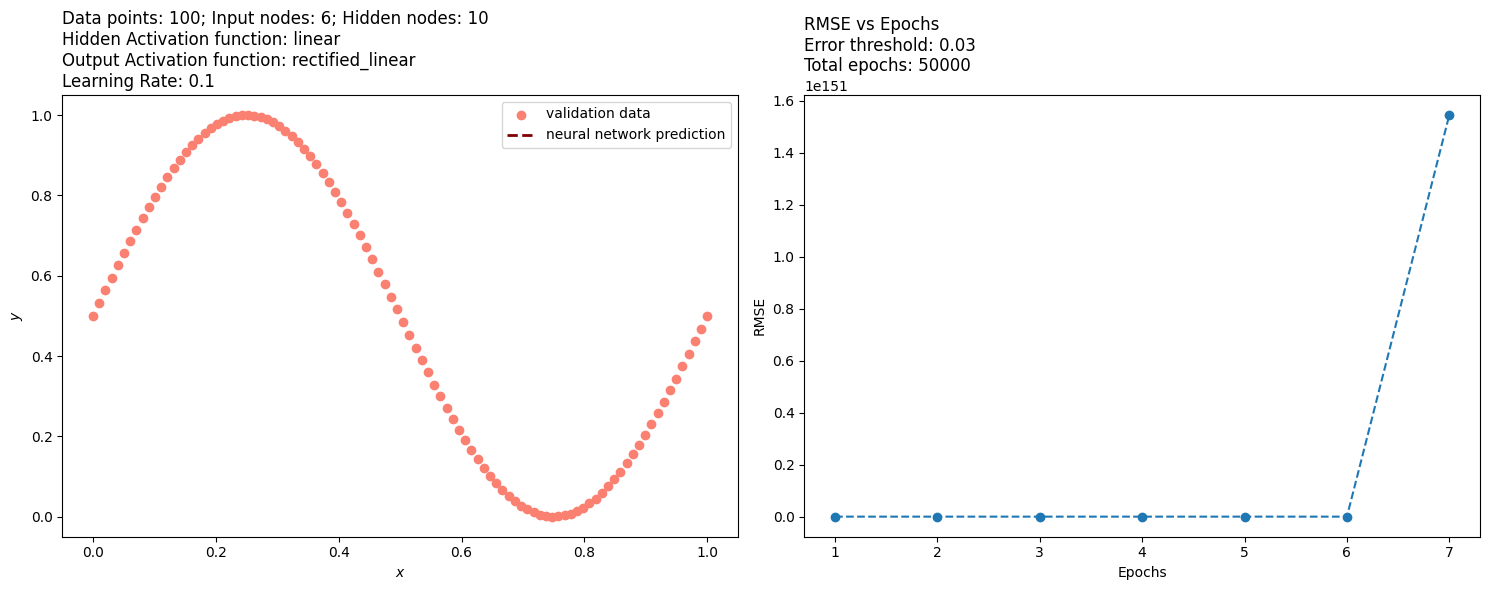

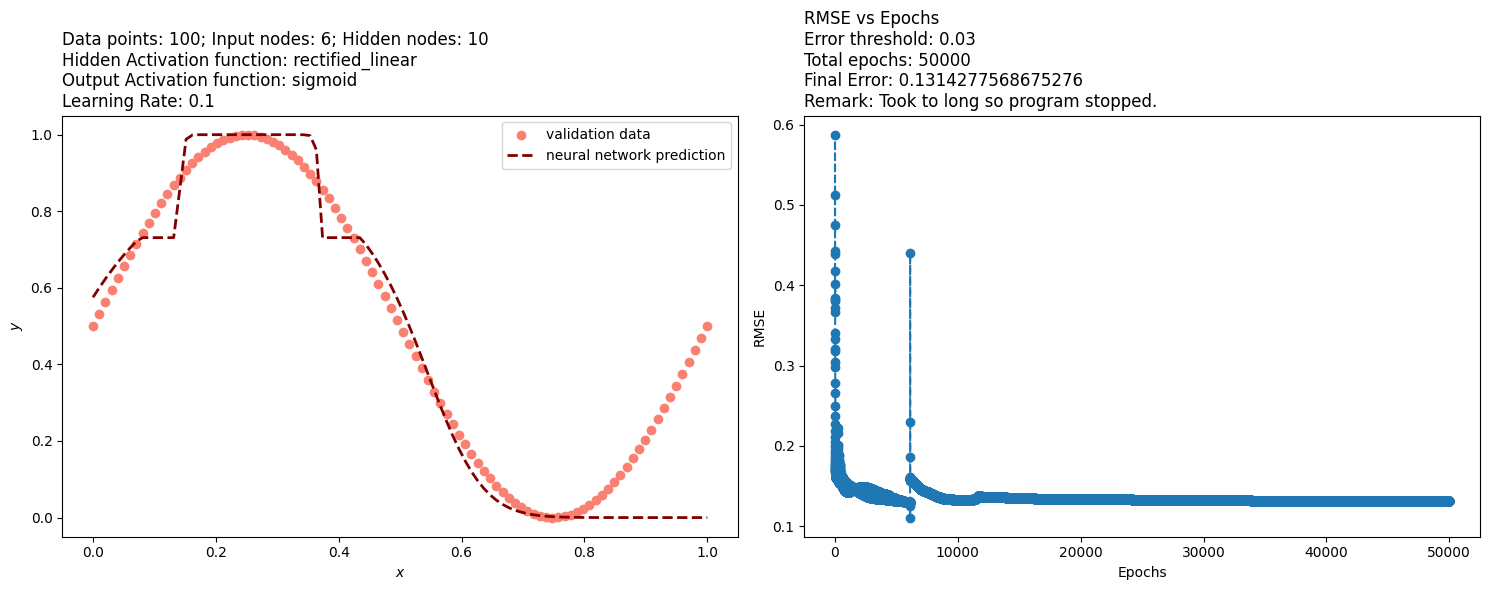

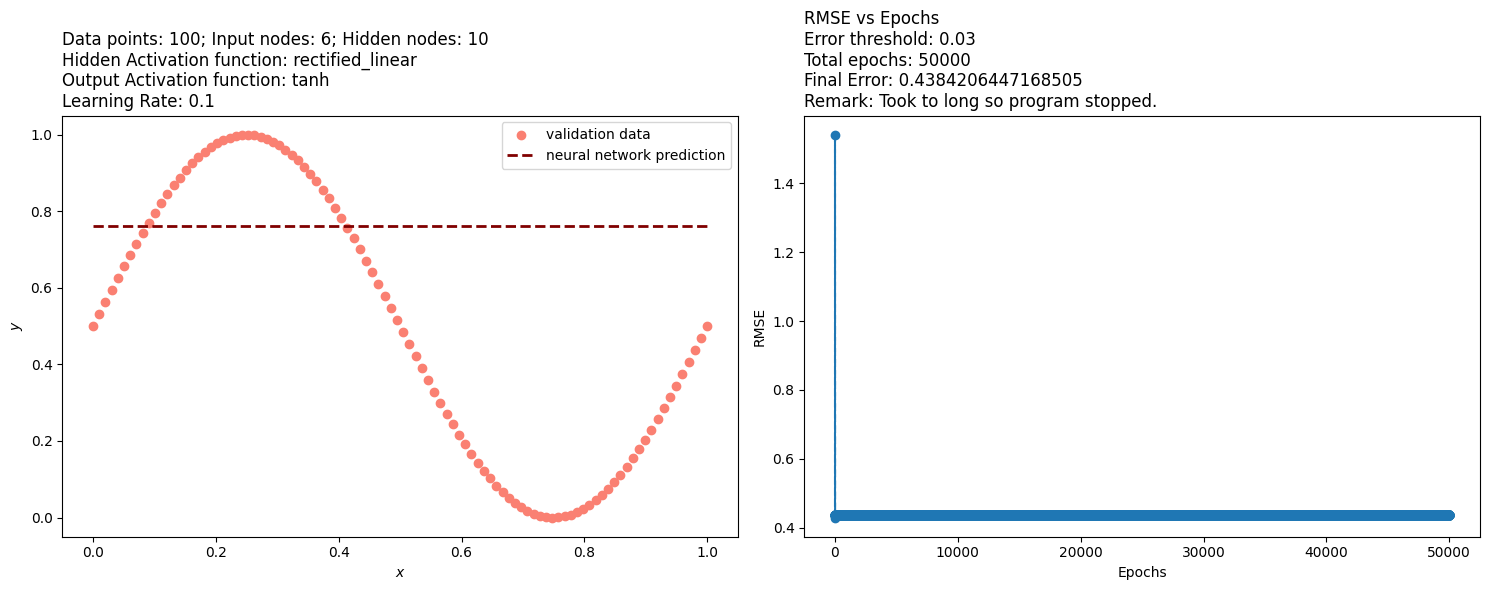

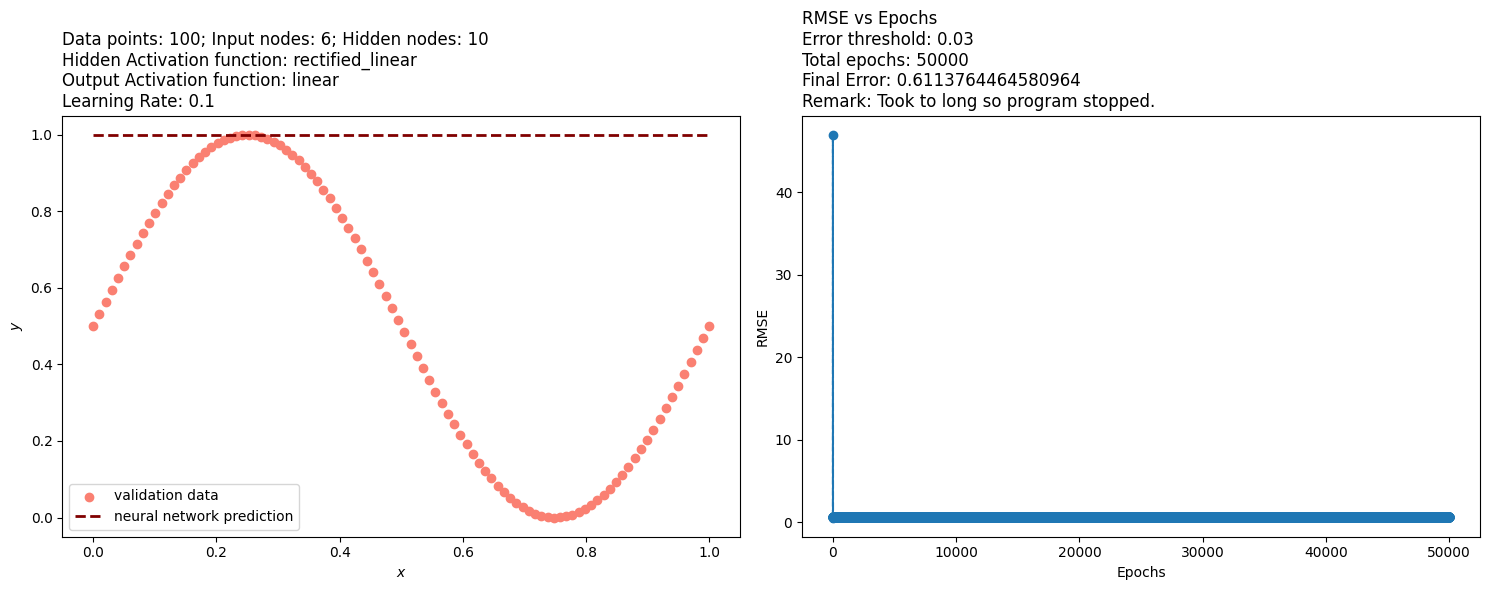

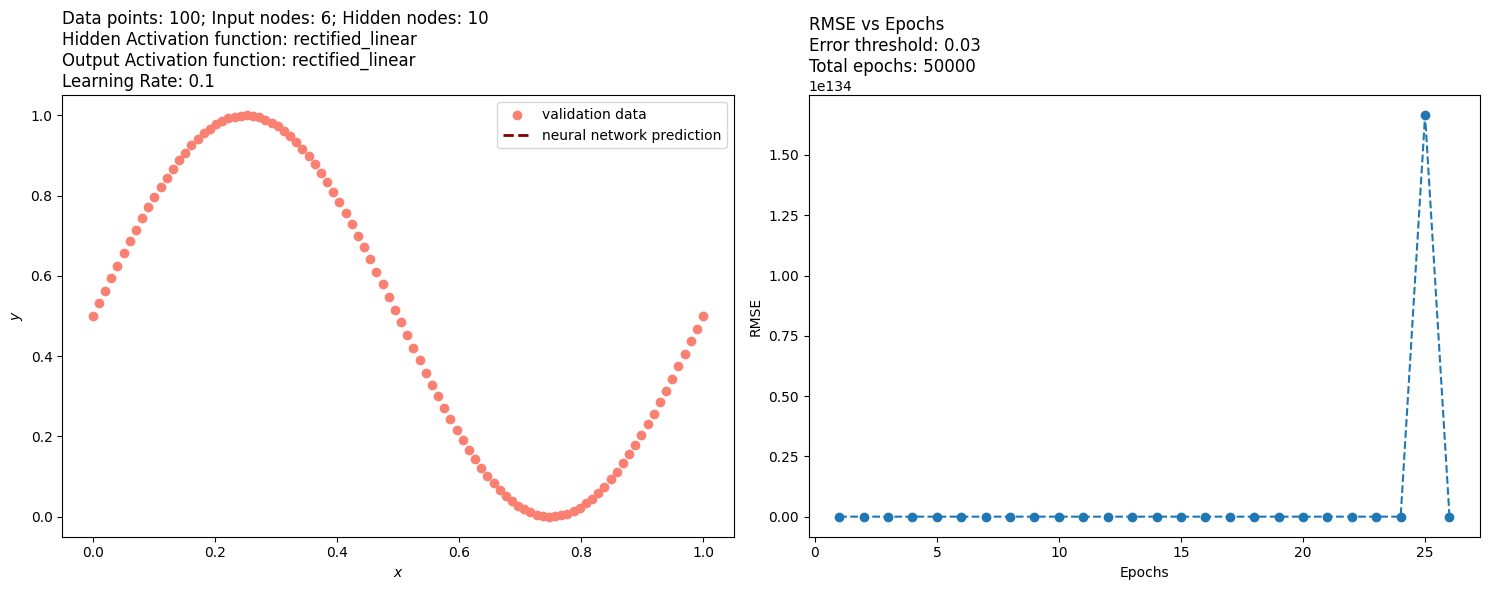

In [29]:
activation_function = [[sigmoid, sigmoid], [sigmoid, tanh], [sigmoid, linear], [sigmoid, rectified_linear],
                       [tanh, sigmoid], [tanh, tanh], [tanh, linear], [tanh, rectified_linear],
                       [linear, sigmoid], [linear, tanh], [linear, linear], [linear, rectified_linear],
                       [rectified_linear, sigmoid], [rectified_linear, tanh], [rectified_linear, linear], [rectified_linear, rectified_linear]
]

for i in activation_function:
    z, RMSE, omega_h, omega_o = start_learning(x_vec, validation, weights_biases, learning_rate, i[0], i[1], error_threshold)
    create_plots(x, z, validation,  RMSE, input_size, hidden_size, i[0], i[1], learning_rate, error_threshold)

### Trying a different model

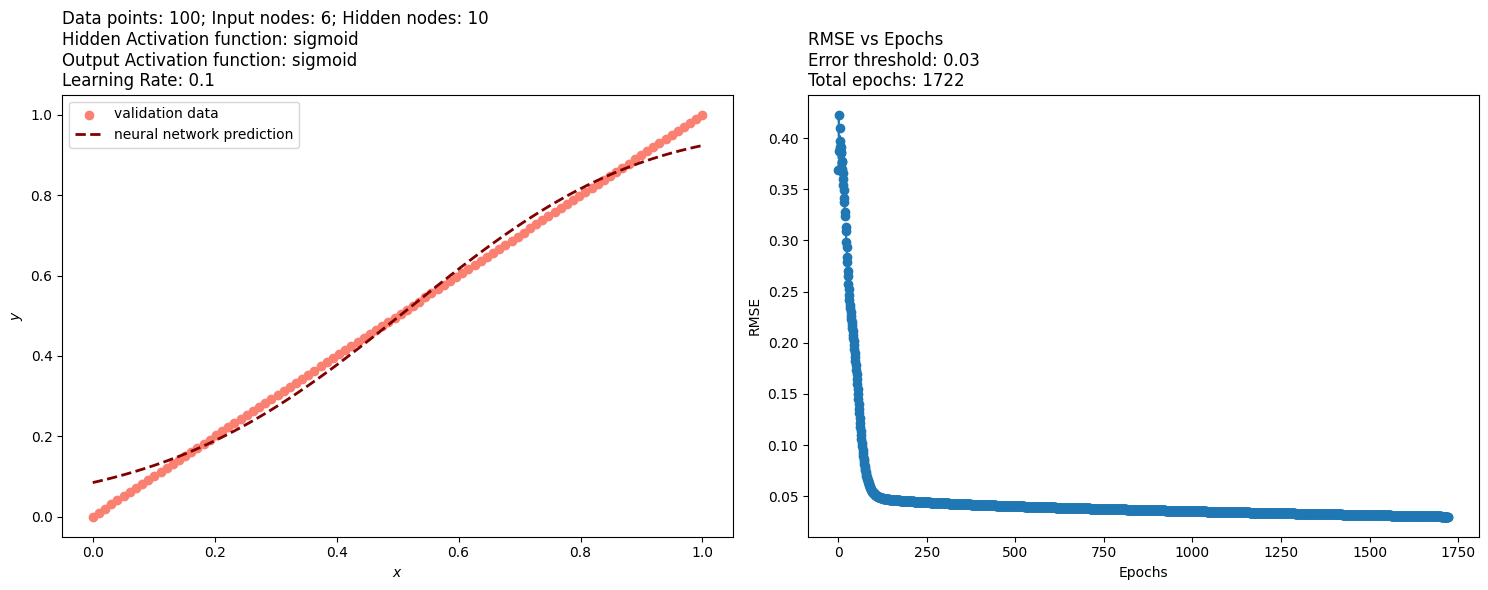

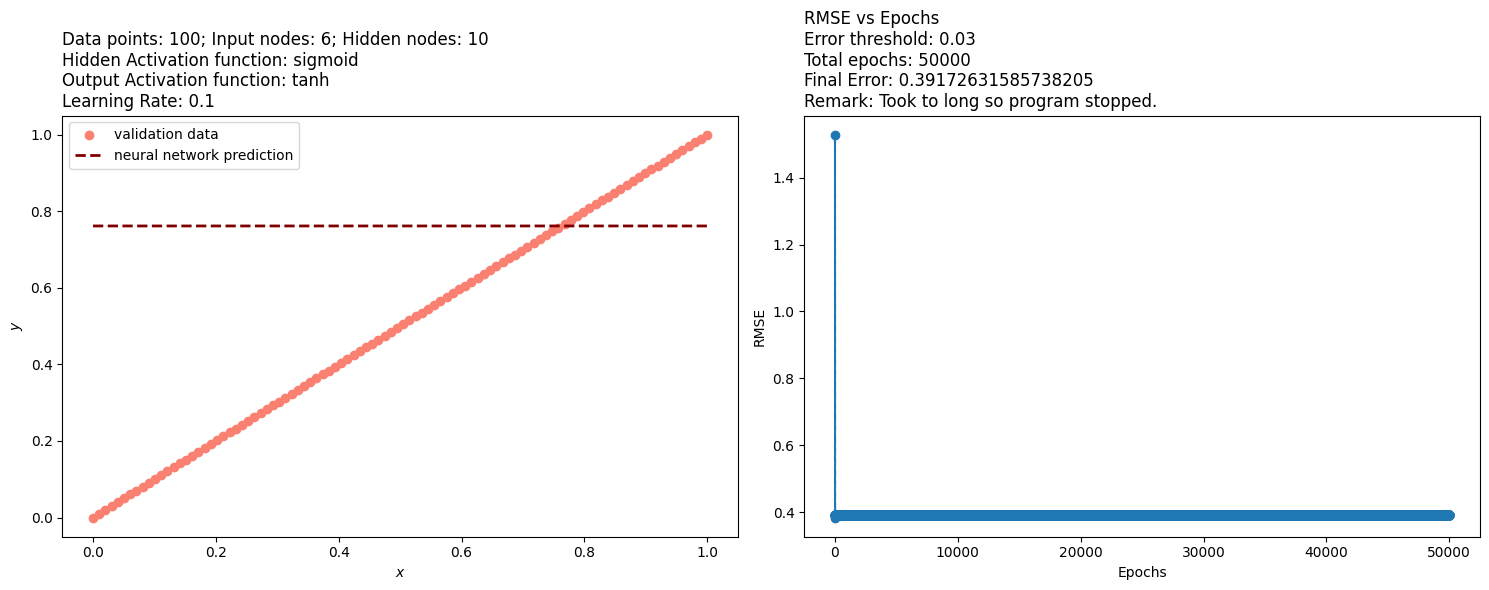

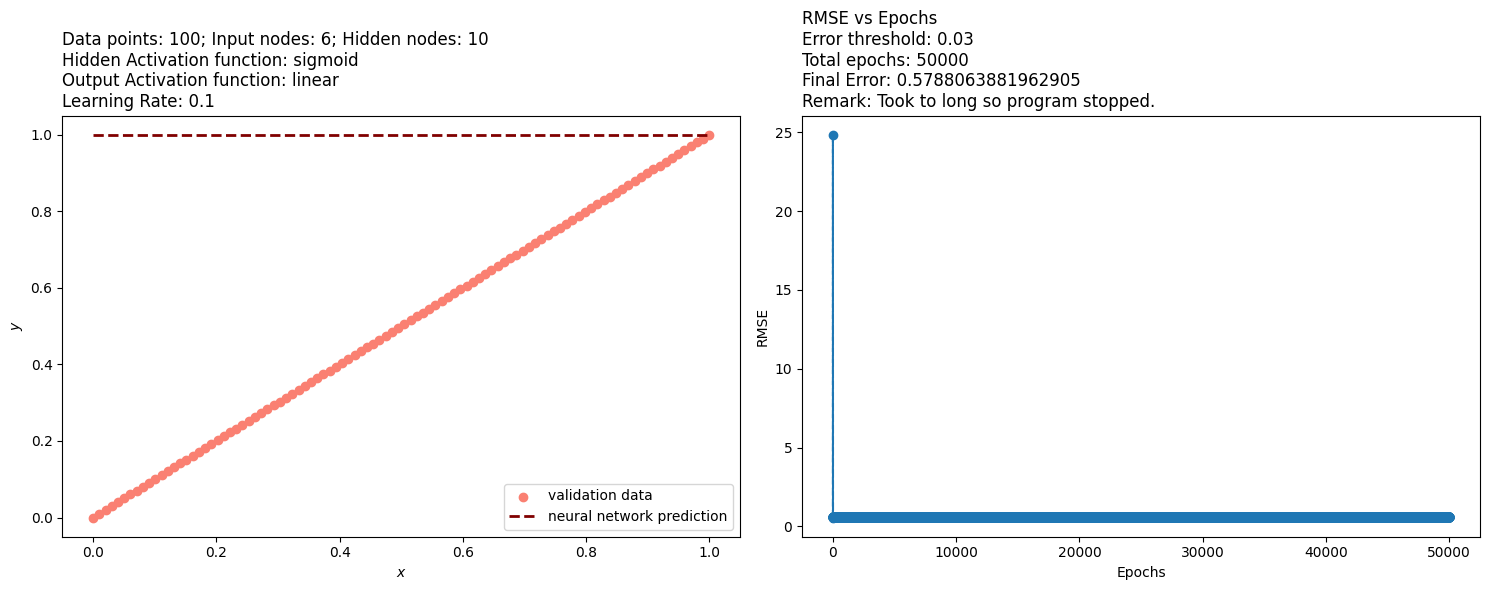

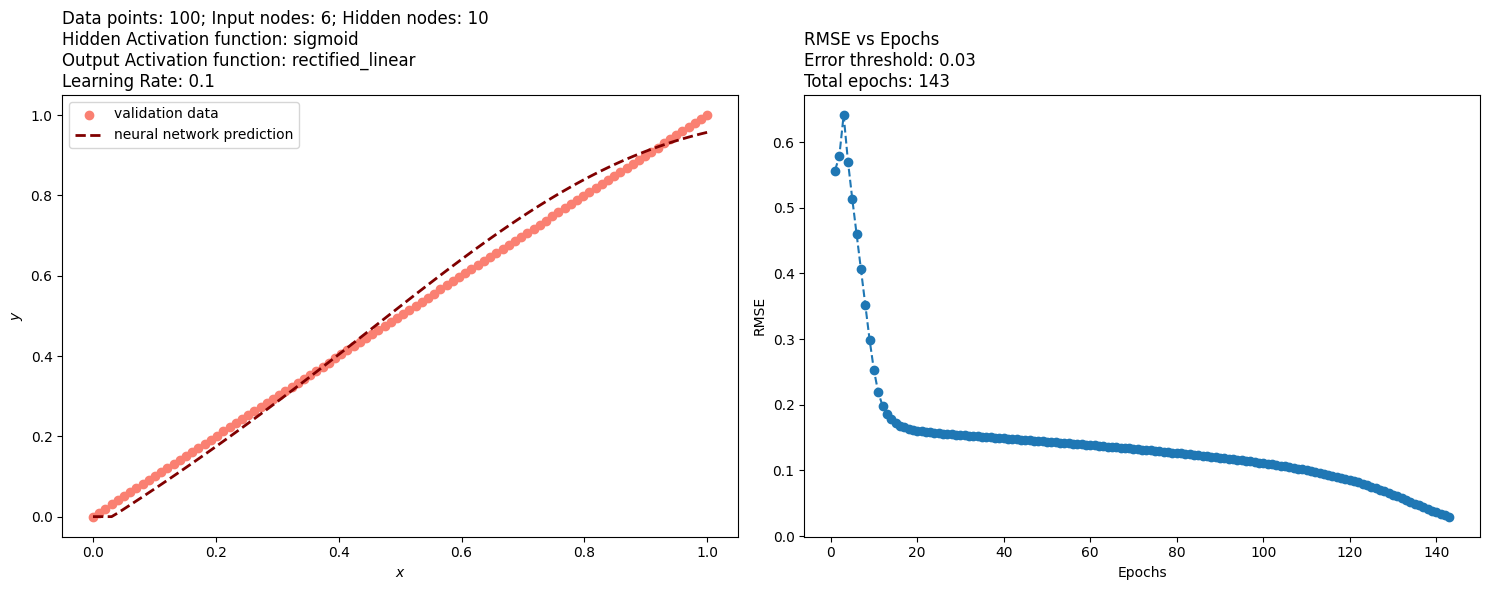

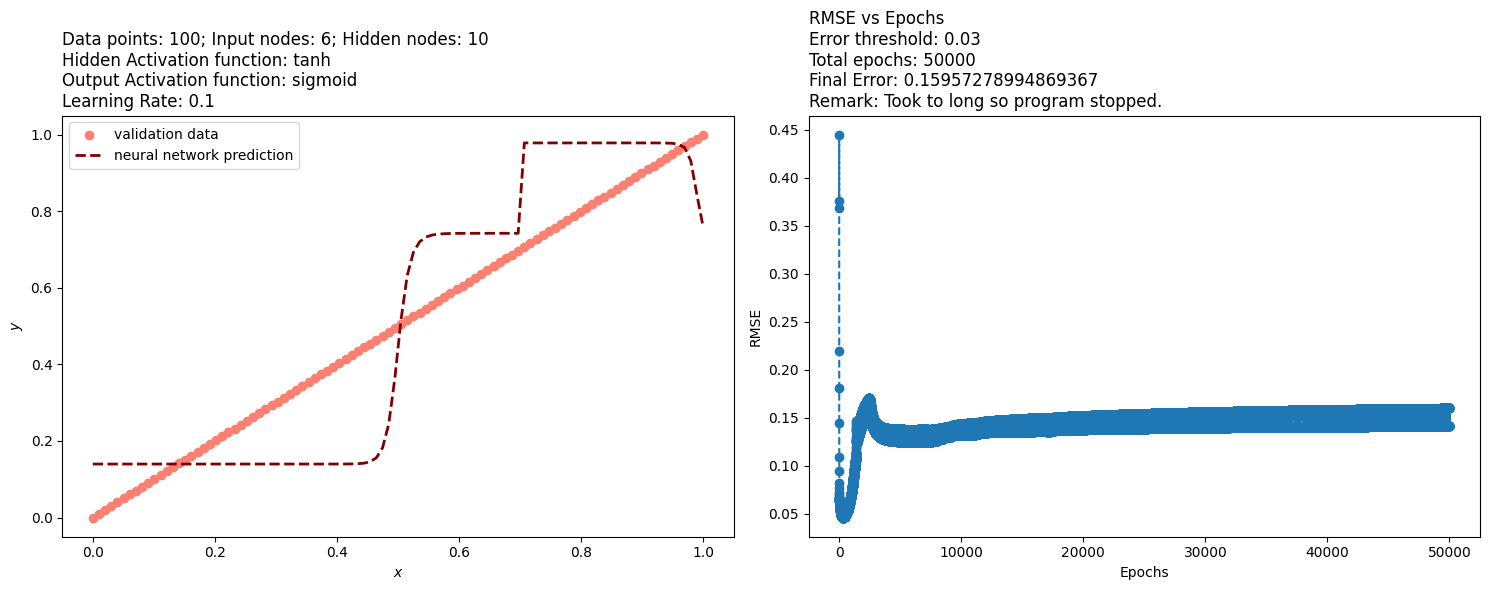

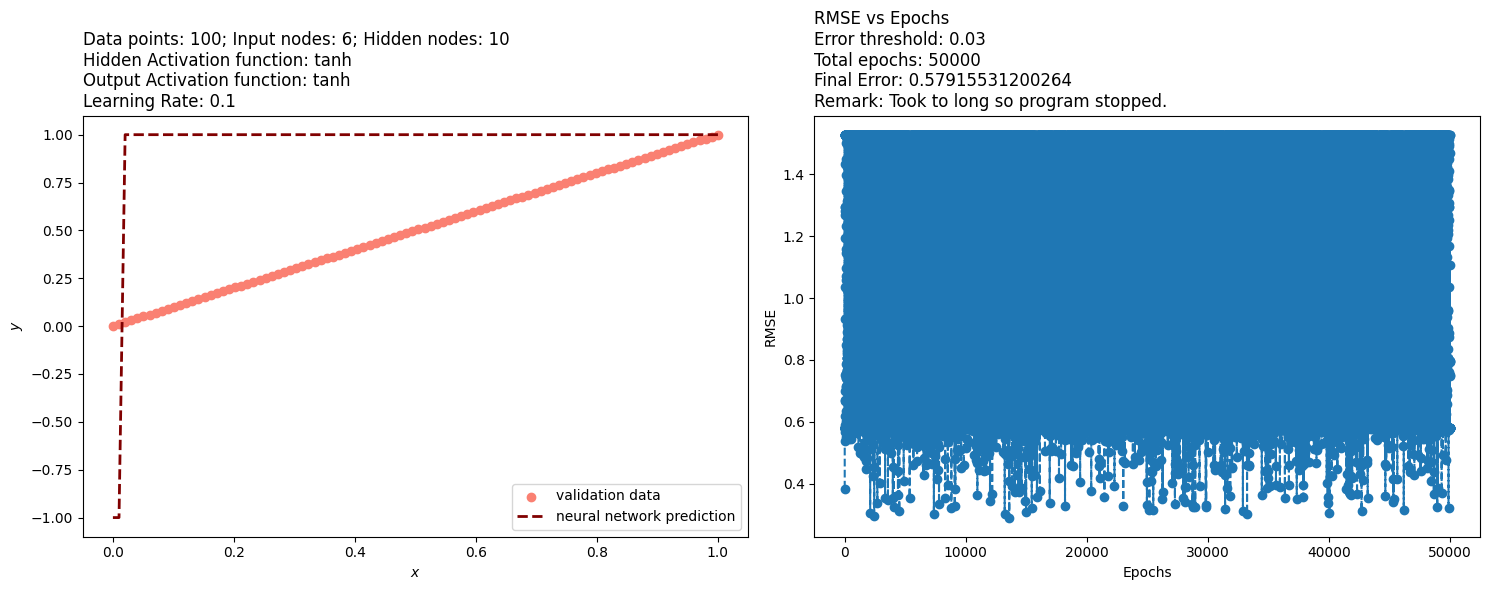

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10288\3404412489.py:21: RuntimeWarning: overflow encountered in square
  current_RMSE = np.sqrt(np.mean(error**2))


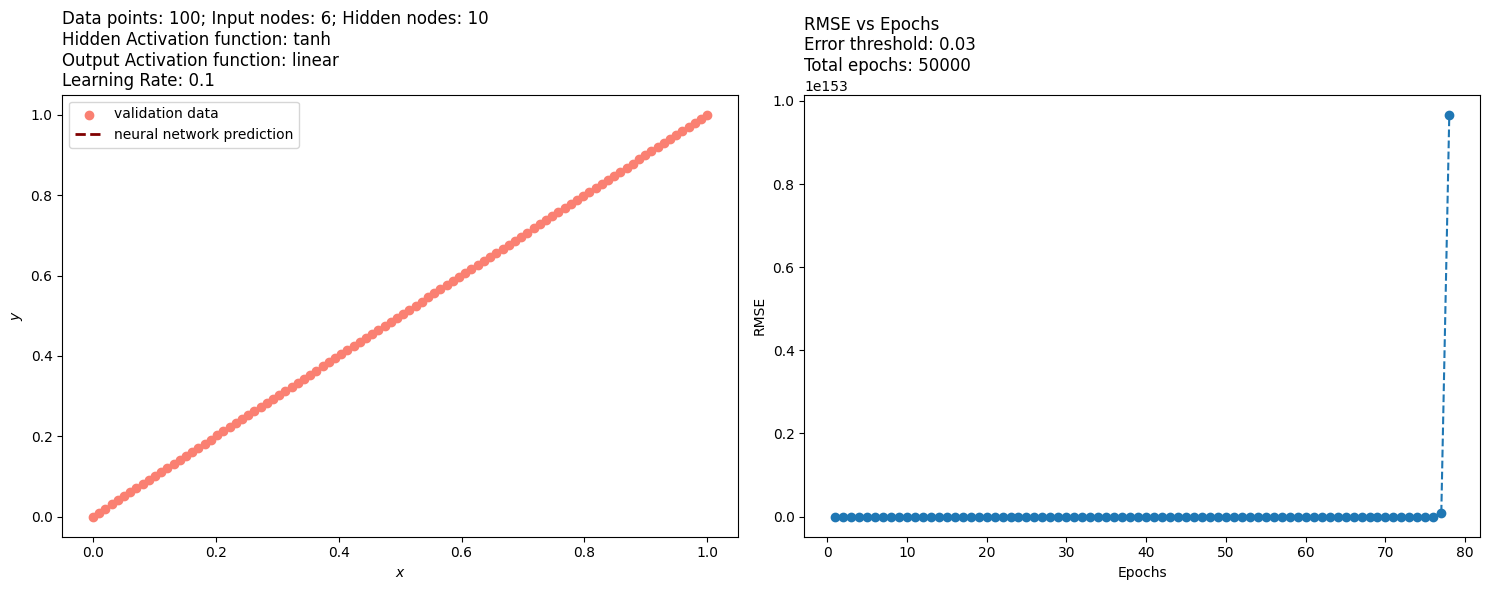

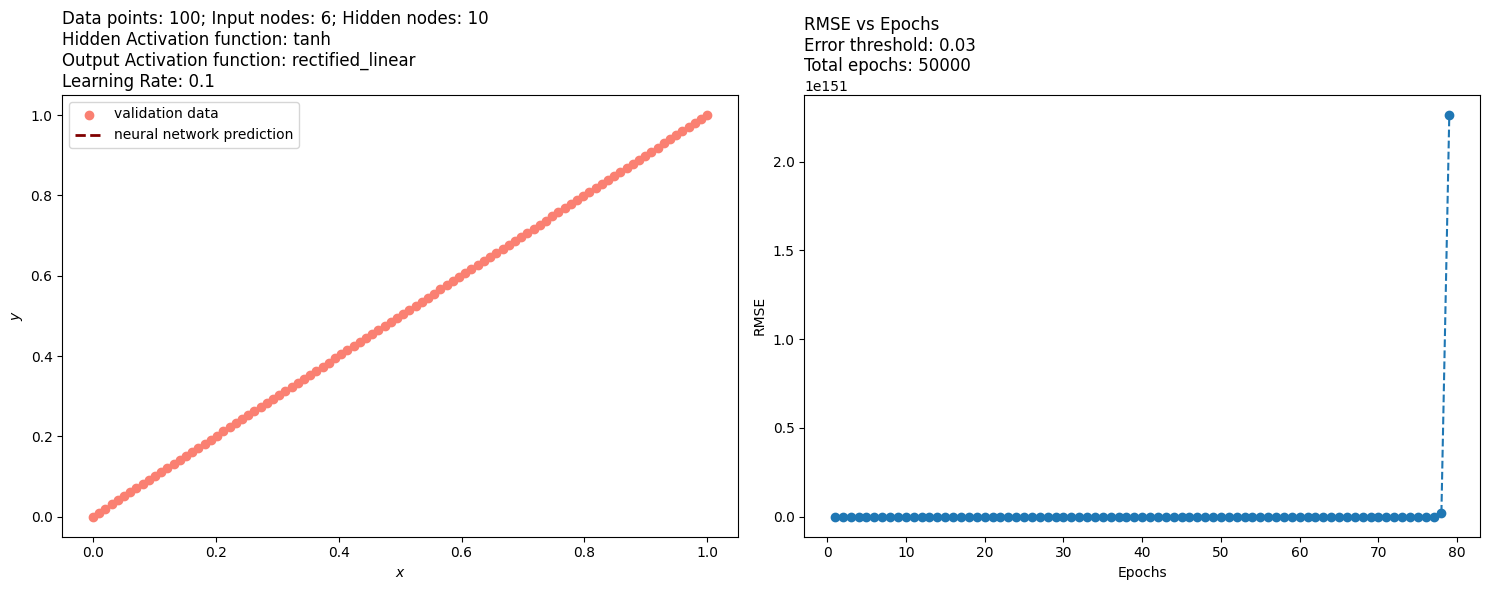

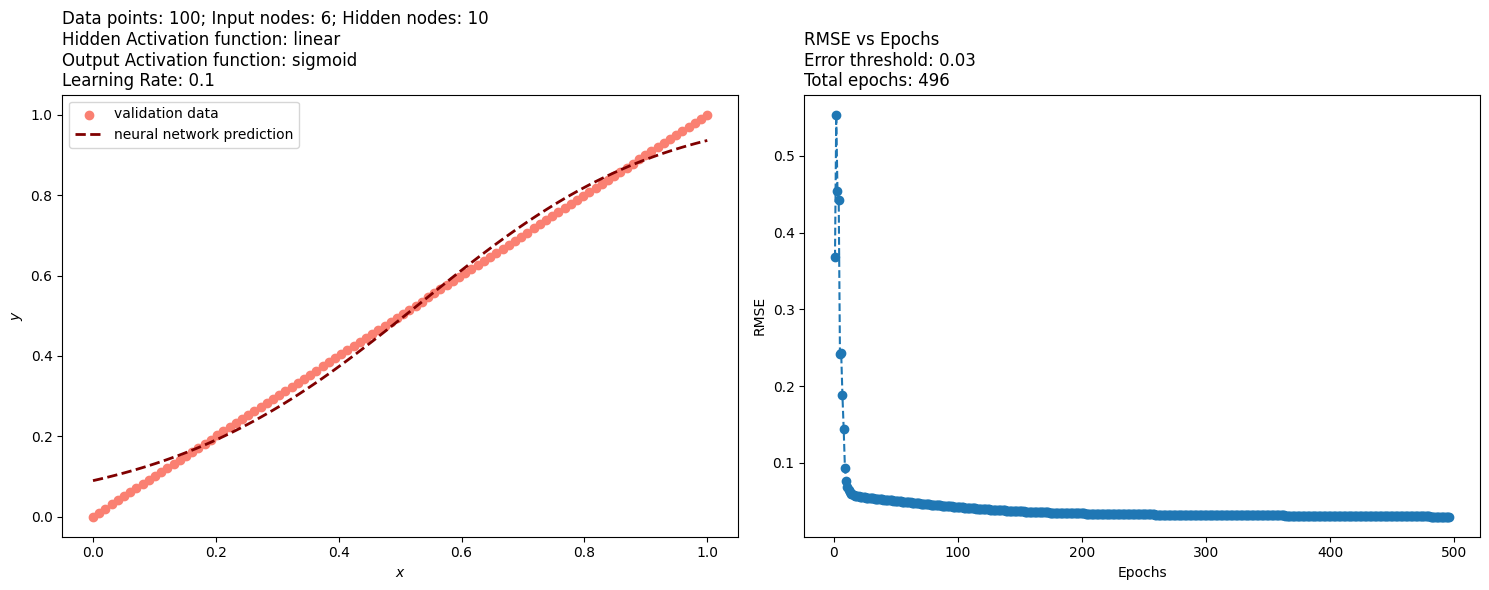

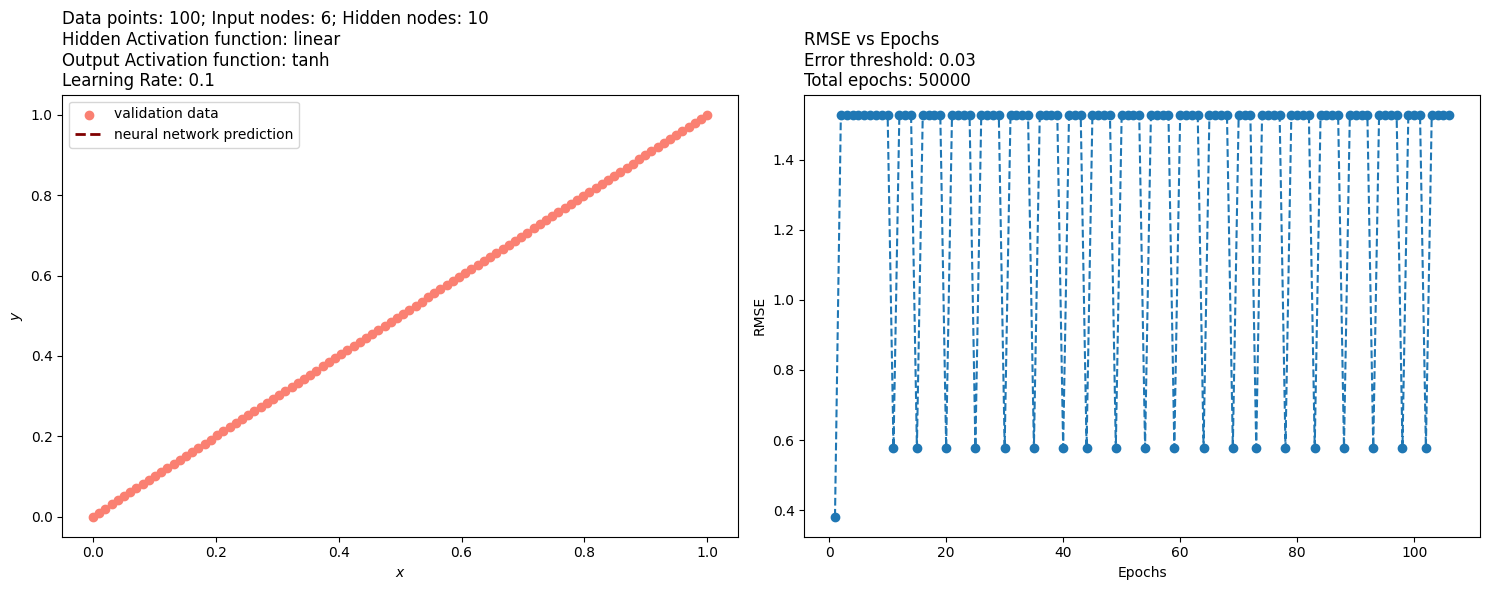

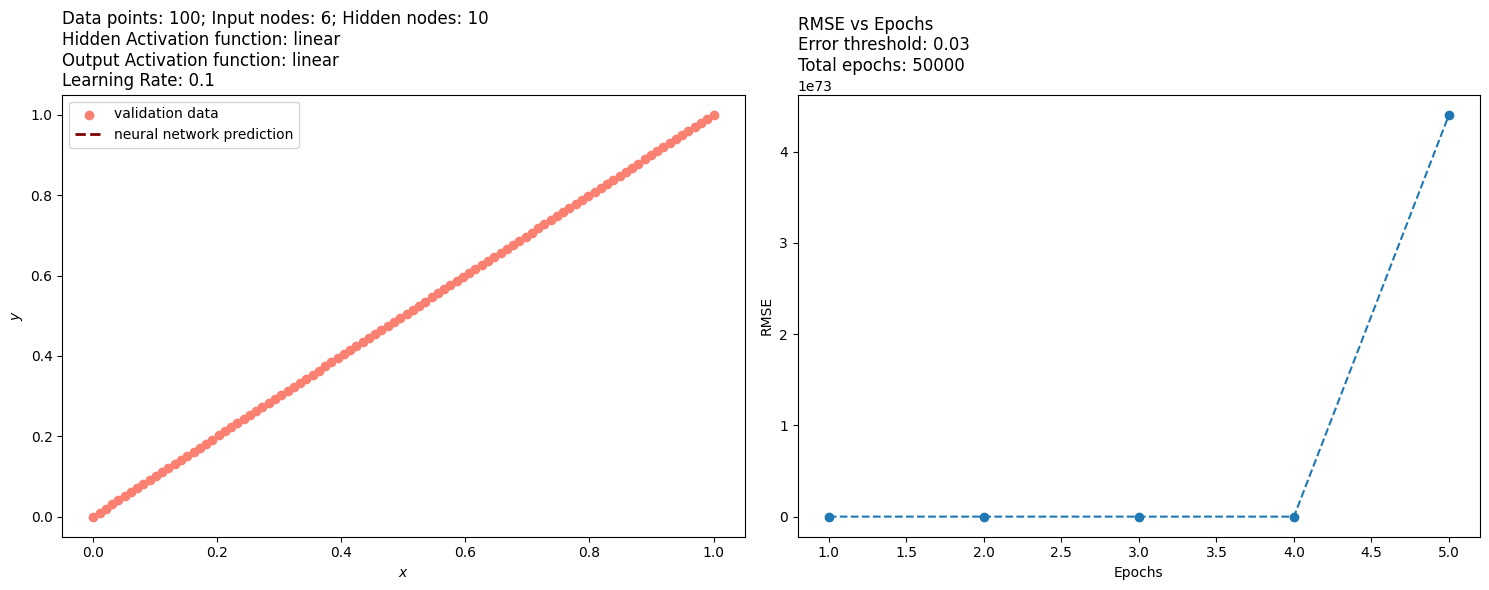

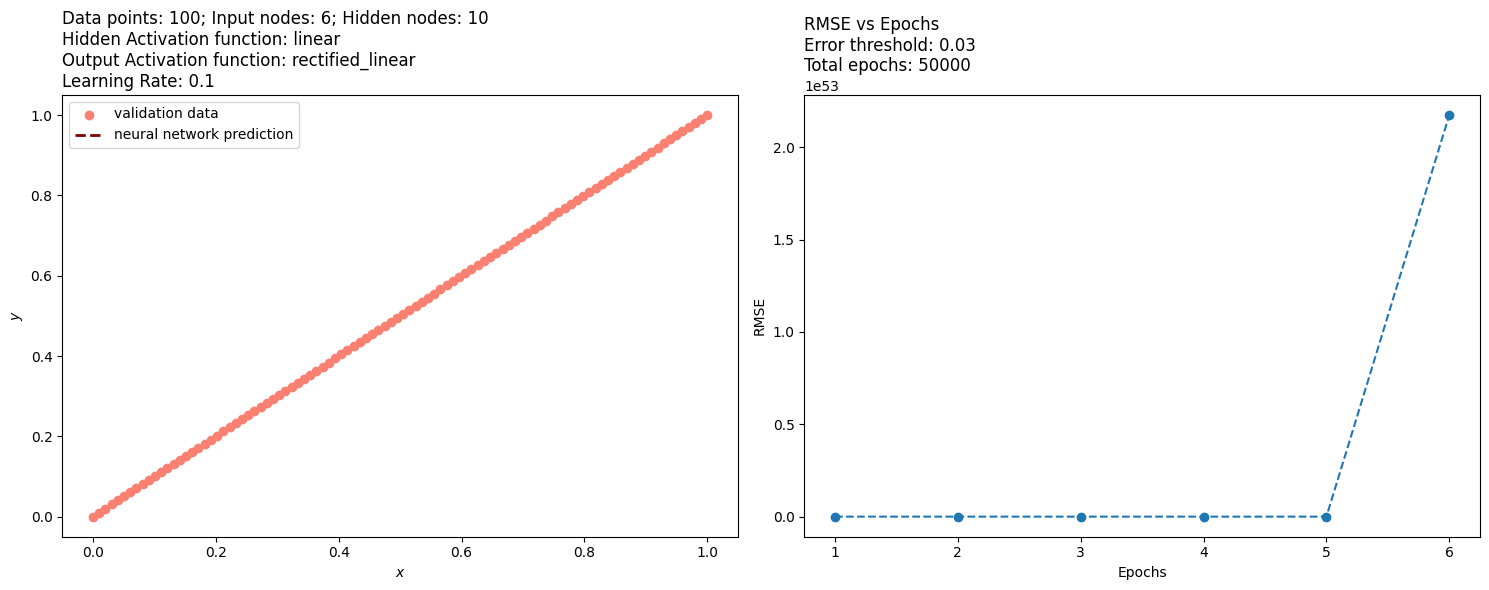

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10288\1809266758.py:9: RuntimeWarning: overflow encountered in exp
  output = 1/(1 + np.exp(-a))


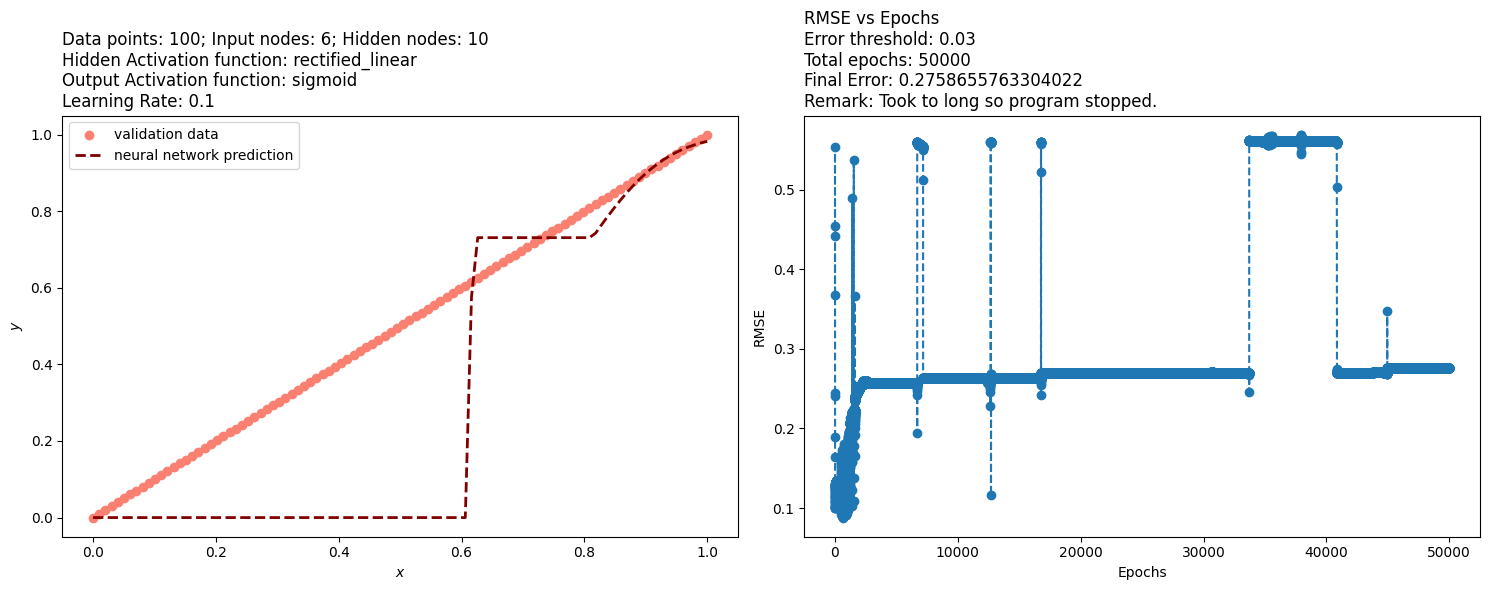

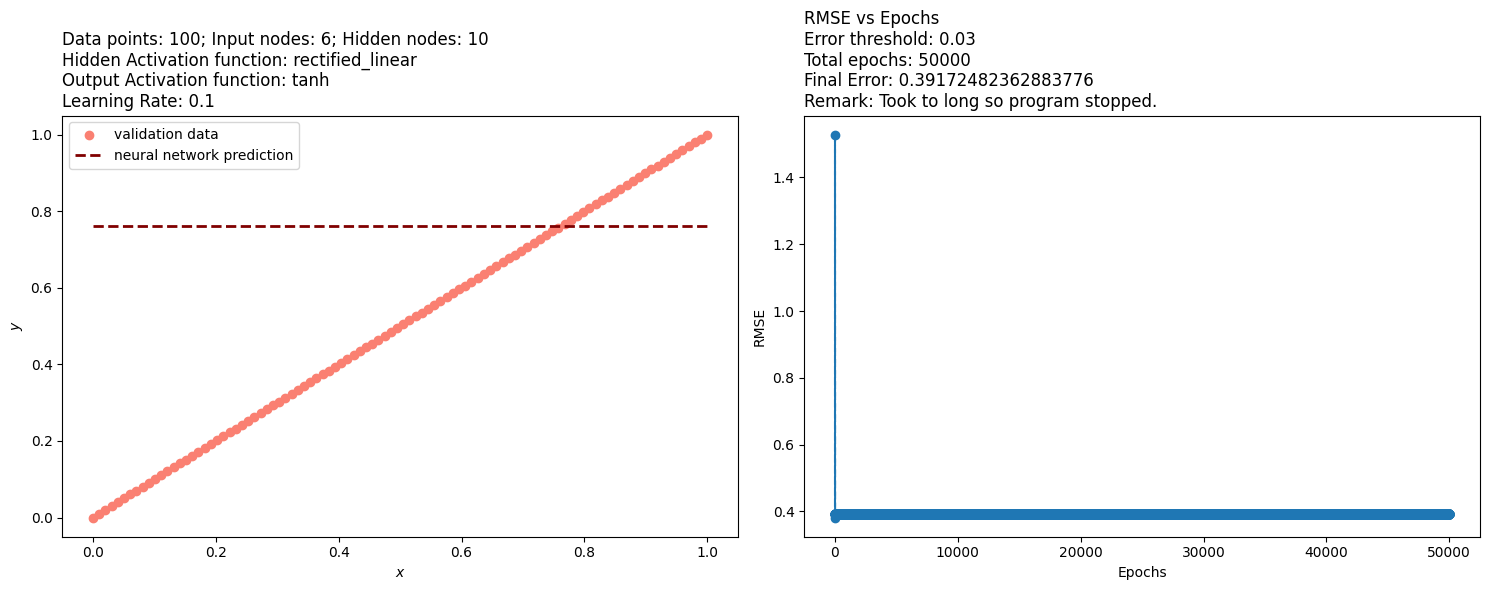

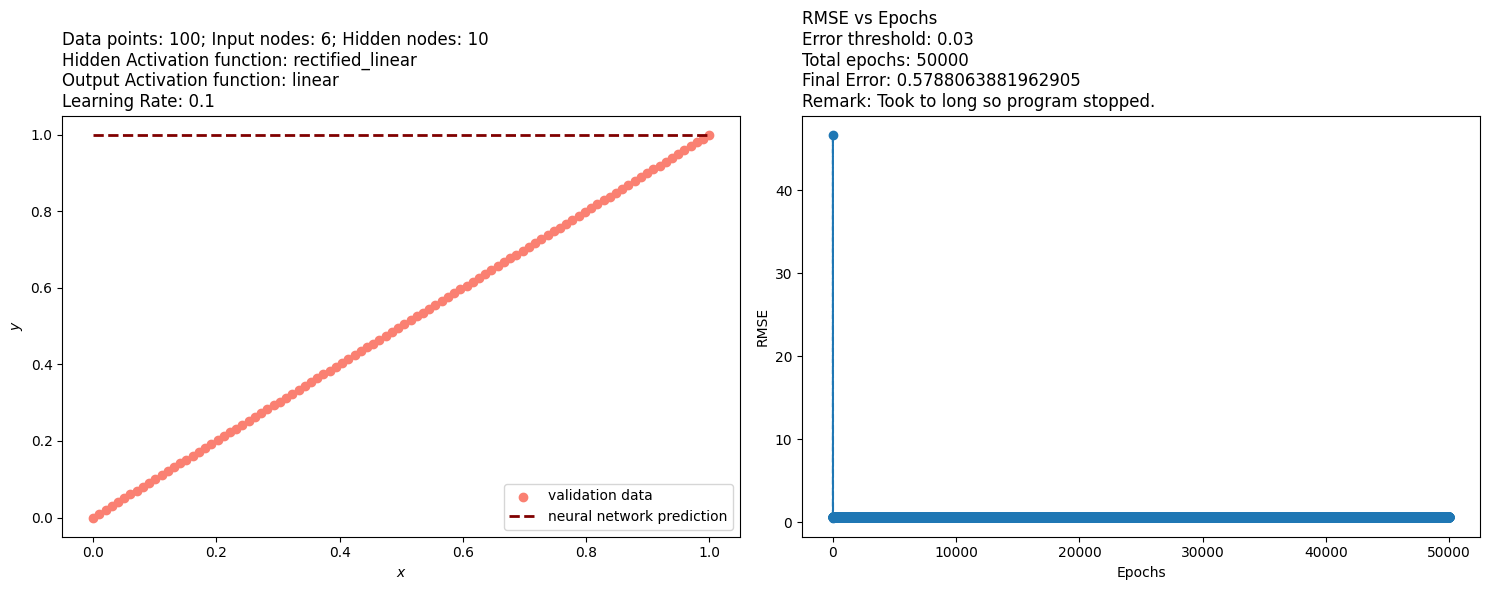

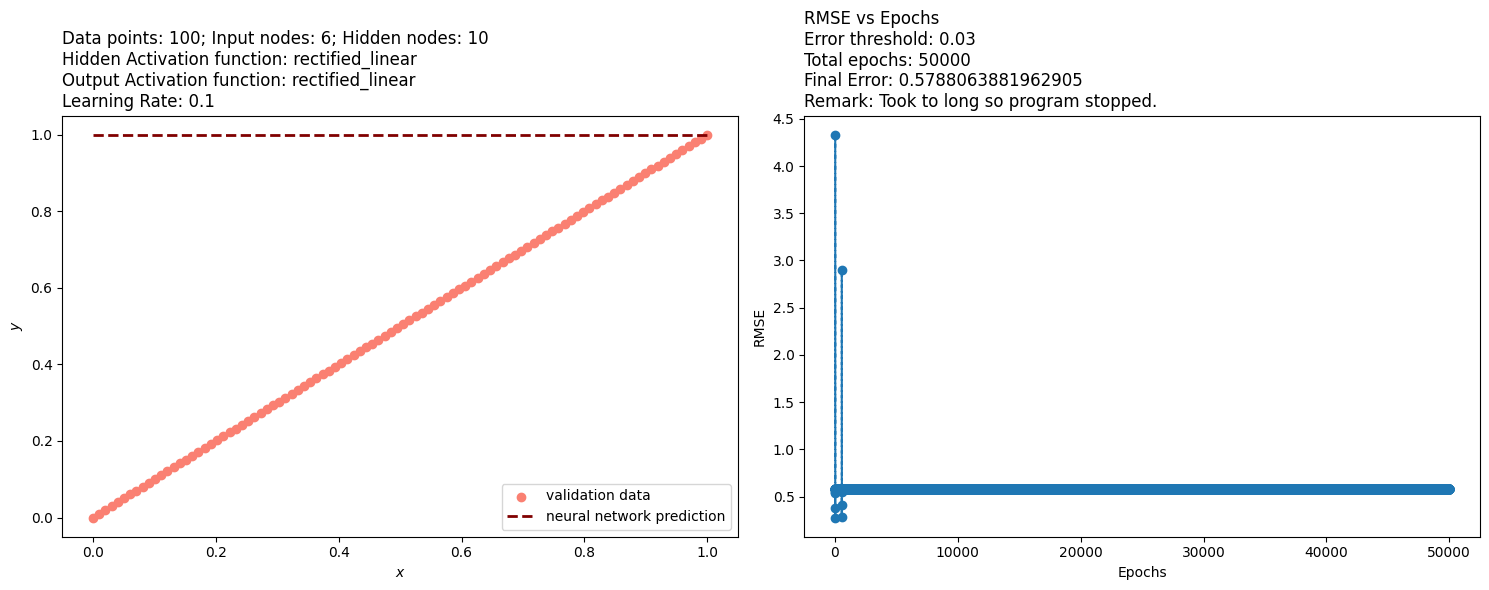

In [30]:
def model2(x):
    return np.reshape(x, (len(x), 1))

validation2 = model2(x)
activation_function = [[sigmoid, sigmoid], [sigmoid, tanh], [sigmoid, linear], [sigmoid, rectified_linear],
                       [tanh, sigmoid], [tanh, tanh], [tanh, linear], [tanh, rectified_linear],
                       [linear, sigmoid], [linear, tanh], [linear, linear], [linear, rectified_linear],
                       [rectified_linear, sigmoid], [rectified_linear, tanh], [rectified_linear, linear], [rectified_linear, rectified_linear]
]

for i in activation_function:
    z, RMSE, omega_h, omega_o = start_learning(x_vec, validation2, weights_biases, learning_rate, i[0], i[1], error_threshold)
    create_plots(x, z, validation2,  RMSE, input_size, hidden_size, i[0], i[1], learning_rate, error_threshold)

# Fruit classification

> #### ${\tt get\_features}$ 
> Gets the desired features from a dataframe.

In [31]:
def get_features(filename1, filename2, features):
    df1 = pd.read_csv(data_repository + filename1)
    df2 = pd.read_csv(data_repository + filename2)

    df1_features = df1.loc[:,features]
    df2_features = df2.loc[:,features]

    return df1_features, df2_features

> #### ${\tt get\_vector}$ 
> Turns the features into vectors and adds a bias of $1$.

In [32]:
def get_vector(data, bias = 1):
    output = data.copy()
    output.insert(0,'bias', bias)
    return np.array(output)

> #### ${\tt normalize\_data}$ 
> Normalizes the average $\textit{g}$ values. Still need to do this because ${\tt convert\_NCC}$ normalized the image back to 0 to 255 to avoid errors in the other functions.

In [33]:
def normalize_data(data_in1, data_in2):
    data_1 = data_in1.copy()
    data_2 = data_in2.copy()

    data_1.iloc[:,1] *= 1/255
    data_2.iloc[:,1] *= 1/255

    return data_1, data_2

## Preprocessing the data
The steps that I used are:
1. Loading the data
2. Turning the data into vectors and adding a bias
3. Splitting the data into training and testing data. The split is $50\%$ training and $50\%$ testing.
4. Creating validation data. The bananas are set to $1$ and apples are set to $0$.
5. Compile all the training data and validation data. It is ordered in such a way that I can do array operations on the compiled data. Basically, the first $n$ rows in both the compiled training and validation data correspond to the banana dataset and the succeeding rows correspond to the apple dataset.

In [69]:
# Loading the data
banana_data, apple_data = get_features('Banana data.csv', 'Apple data.csv', ['eccentricity', 'ave_g'])
norm_banana_data, norm_apple_data = normalize_data(banana_data, apple_data)

# Adding bias to the data
banana_vector = get_vector(norm_banana_data, bias = 1)
apple_vector = get_vector(norm_apple_data, bias = 1)

# Splitting into training and testing data
banana_train, banana_test, apple_train, apple_test = train_test_split(banana_vector, apple_vector, train_size= .5)

# Creating validation data
banana_validation = np.tile(1, (len(banana_train), 1))
apple_validation = np.tile(0, (len(apple_train), 1))

# Compiling training and validation data
overall_train = np.concatenate((banana_train, apple_train))
overall_validation = np.concatenate((banana_validation, apple_validation))

> #### ${\tt plot\_RMSE}$ 
> Plots the RMSE as a function of epochs.

In [96]:
def plot_RMSE(data_points, RMSE, input_size, hidden_size, afunc_h, afunc_o, learning_rate, error_threshold):
    epochs = np.arange(1, len(RMSE)+1, 1)
    
    fig, ax = plt.subplots(figsize= (10,6))
    ax.plot(epochs, RMSE, linestyle = '--', marker = 'o')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE vs Epochs' +
                    '\nData points: ' + str(data_points) +
                    '; Input nodes: ' + str(input_size) +
                    '; Hidden nodes: ' + str(hidden_size) +
                    '\nHidden Activation function: ' + str(afunc_h.__name__) +
                    '\nOutput Activation function: ' + str(afunc_o.__name__) +
                    '\nLearning Rate: ' + str(learning_rate) +
                    '\nError threshold: ' + str(error_threshold) +
                    '\nTotal epochs: ' + str(len(RMSE)) +
                    '\nFinal Error: ' + str(RMSE[len(RMSE)-1]),
                    loc = 'left'
    )
    plt.show()

## Now testing my neural network for Fruit Classification

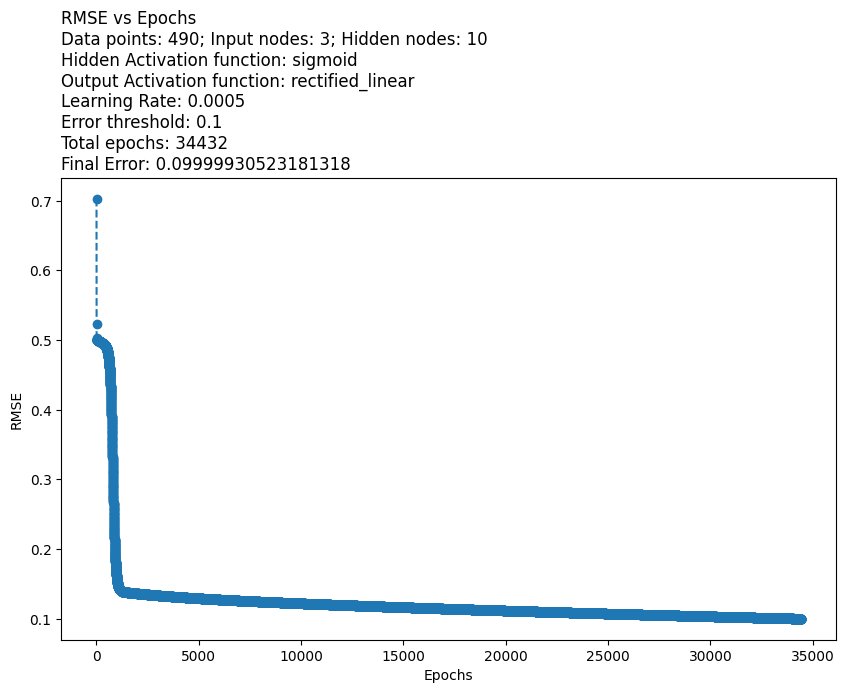

In [97]:
# Setting the parameters
input_size = len(overall_train[0])
hidden_size = 10
learning_rate = 0.0005
error_threshold = 0.1
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= sigmoid
activation_function2= rectified_linear

# Starting the learning process
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)

> #### ${\tt fruit\_classification\_test}$ 
> Tests the accuracy of the model in classifying fruits. The accuracy is measured by the following formula
> $$ \text{accuracy} = \frac{\text{\#~\text{correct classifications}}}{\text{total number of data points}}\times 100\%$$

In [98]:
def fruit_classification_test(testing, validation, label1, label2, textlabel1, textlabel2, real_classification, omega_h, omega_o, afunc_hidden, afunc_out):
    bias0, bias1 = 1,1
    
    # Getting outputs of the hidden layer
    aji = np.dot(testing, omega_h.T)
    hidden_layer = afunc_hidden(aji + bias0)
            
    # Getting output 
    ak = np.dot(hidden_layer, omega_o.T) 
    output_layer = afunc_out(ak + bias1)
    
    # Rounding off to the nearest integer
    output_layer = (np.rint(output_layer)).astype(int)
    
    # Making the dataframe
    test_image_names = []
    for i in range(1, len(testing) + 1):
        test_image_names.append('Test_image_'+str(i))
        
    df = pd.DataFrame({ 'Test image': test_image_names,
                        'Actual Classification' : real_classification
    })
    df.insert(len(df.iloc[0]),'Neural Network Prediction', None)

    df.loc[output_layer[:,0] == label1,'Neural Network Prediction'] = textlabel1
    df.loc[output_layer[:,0] == label2,'Neural Network Prediction'] = textlabel2
    
    accuracy = (len(df[df['Neural Network Prediction'] == real_classification]))/len(df)

    return df, accuracy
    

### Displaying the classifications

In [99]:
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
display(banana_classifications)
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')
display(apple_classifications)

Accuracy of neural network for classifying bananas:  100.0 %


,Test image,Actual Classification,Neural Network Prediction
0,Test_image_1,Banana,Banana
1,Test_image_2,Banana,Banana
2,Test_image_3,Banana,Banana
3,Test_image_4,Banana,Banana
4,Test_image_5,Banana,Banana
...,...,...,...
240,Test_image_241,Banana,Banana
241,Test_image_242,Banana,Banana
242,Test_image_243,Banana,Banana
243,Test_image_244,Banana,Banana


Accuracy of neural network for classifying apples:  100.0 %


,Test image,Actual Classification,Neural Network Prediction
0,Test_image_1,Apple,Apple
1,Test_image_2,Apple,Apple
2,Test_image_3,Apple,Apple
3,Test_image_4,Apple,Apple
4,Test_image_5,Apple,Apple
...,...,...,...
240,Test_image_241,Apple,Apple
241,Test_image_242,Apple,Apple
242,Test_image_243,Apple,Apple
243,Test_image_244,Apple,Apple


## Testing other combinations of activation functions

### linear and rectified linear

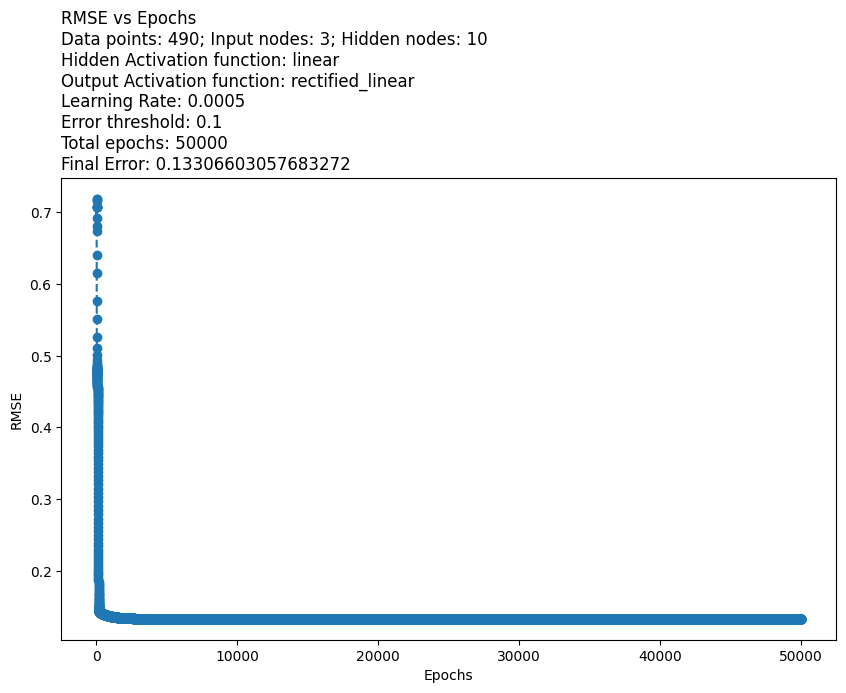

Accuracy of neural network for classifying bananas:  99.59183673469387 %
Accuracy of neural network for classifying apples:  100.0 %


In [106]:
# Setting parameters
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= linear
activation_function2= rectified_linear

# Learning
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)


# Accuracy and tables
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')


### sigmoid and sigmoid

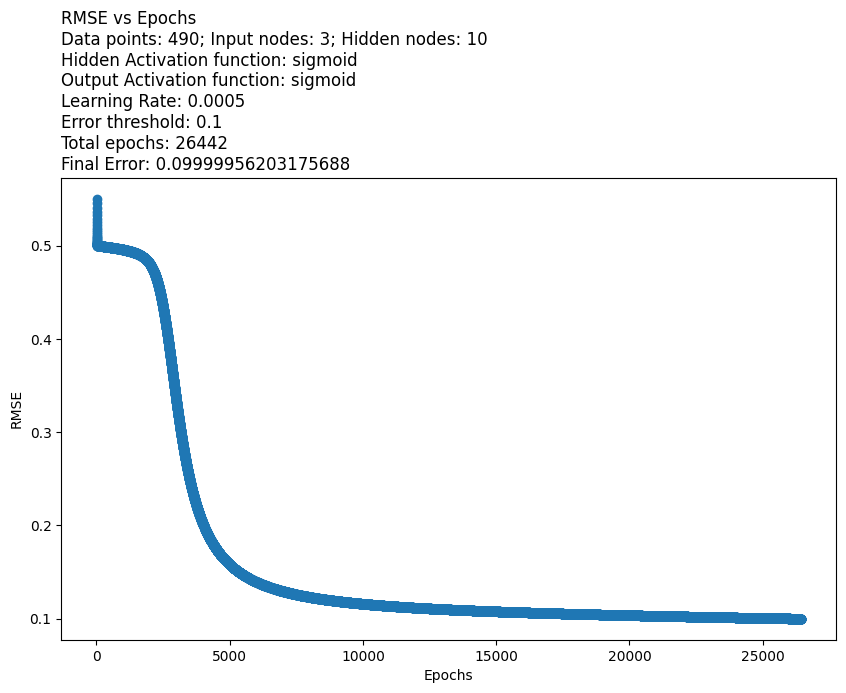

Accuracy of neural network for classifying bananas:  100.0 %
Accuracy of neural network for classifying apples:  100.0 %


In [107]:
# Setting parameters
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= sigmoid
activation_function2= sigmoid

# Learning
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)


# Accuracy and tables
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')

### linear and sigmoid

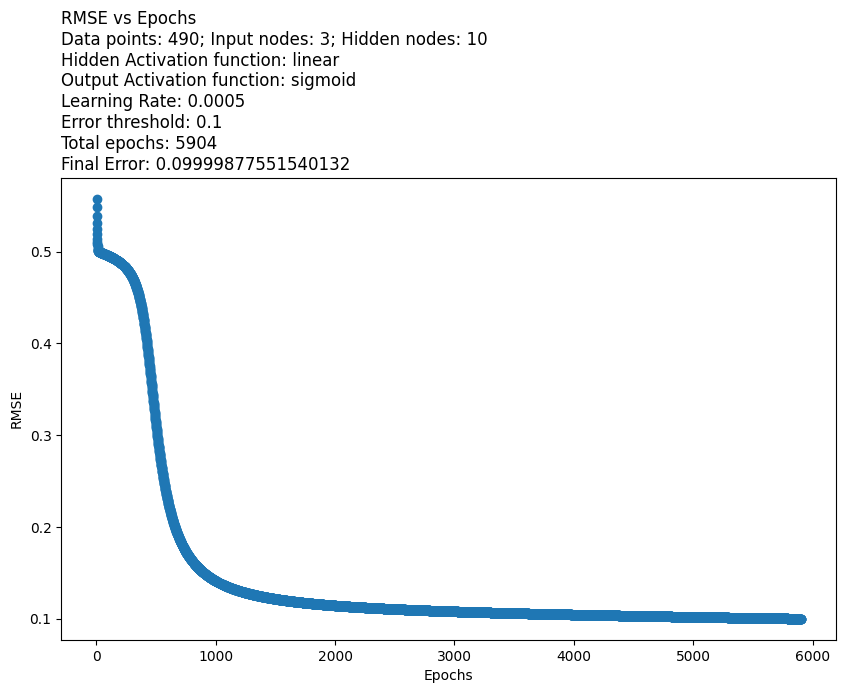

Accuracy of neural network for classifying bananas:  100.0 %
Accuracy of neural network for classifying apples:  100.0 %


In [108]:
# Setting parameters
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= linear
activation_function2= sigmoid

# Learning
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)


# Accuracy and tables
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')

### tanh and sigmoid

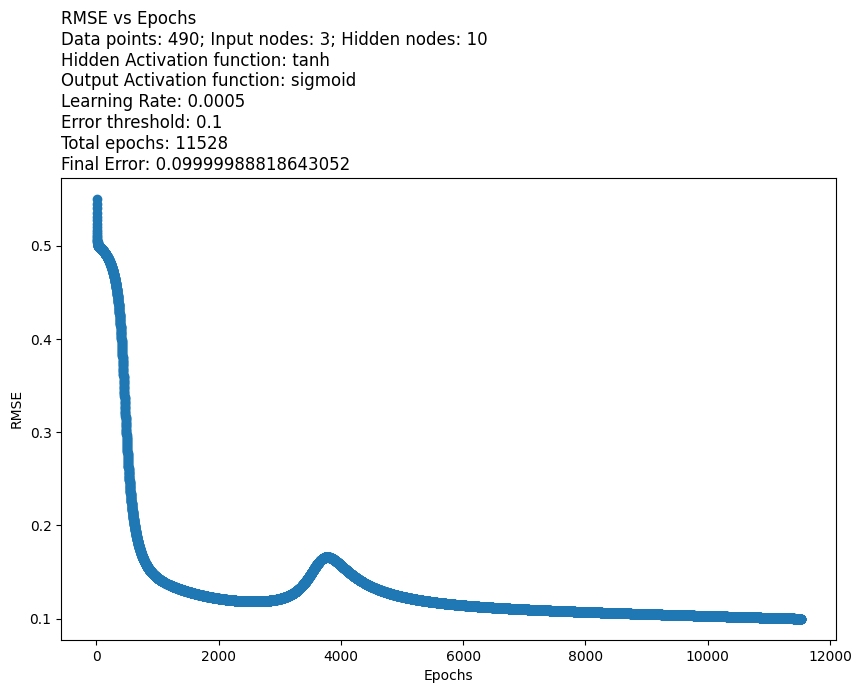

Accuracy of neural network for classifying bananas:  100.0 %
Accuracy of neural network for classifying apples:  100.0 %


In [109]:
# Setting parameters
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= tanh
activation_function2= sigmoid

# Learning
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)


# Accuracy and tables
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')

### tanh and tanh

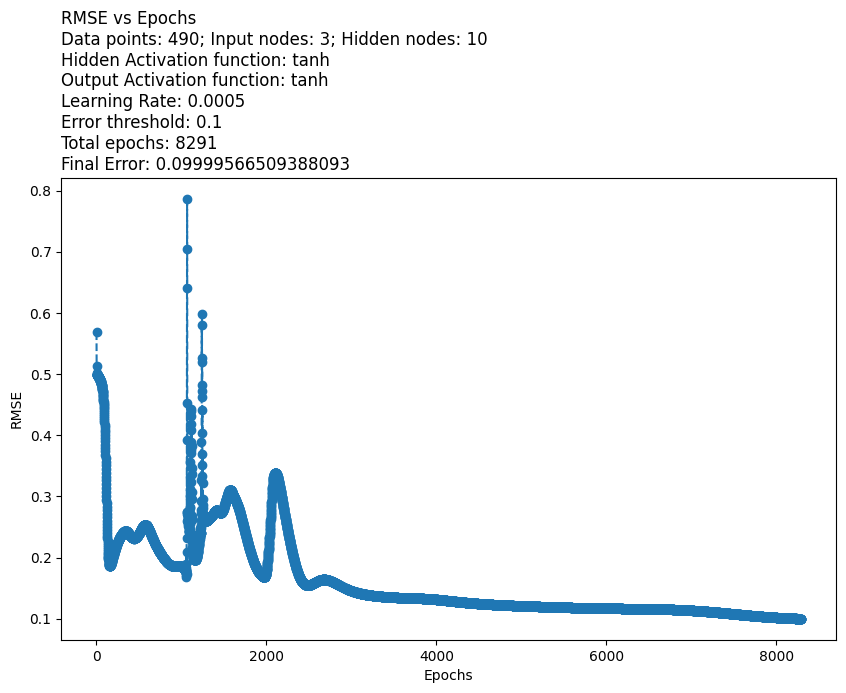

Accuracy of neural network for classifying bananas:  100.0 %
Accuracy of neural network for classifying apples:  100.0 %


In [110]:
# Setting parameters
weights_biases = initialize_weights_biases(input_size, hidden_size, 1)
activation_function1= tanh
activation_function2= tanh

# Learning
z, RMSE, omega_h, omega_o = start_learning(overall_train, overall_validation, weights_biases, learning_rate, activation_function1, activation_function2, error_threshold)
plot_RMSE(len(z), RMSE, input_size, hidden_size, activation_function1, activation_function2, learning_rate, error_threshold)


# Accuracy and tables
banana_classifications, banana_accuracy = fruit_classification_test(banana_test, banana_validation, 1, 0, 'Banana', 'Apple', 'Banana', omega_h, omega_o, activation_function1, activation_function2)
apple_classifications, apple_accuracy = fruit_classification_test(apple_test, apple_validation, 1, 0, 'Banana', 'Apple', 'Apple', omega_h, omega_o, activation_function1, activation_function2)
print('Accuracy of neural network for classifying bananas: ', banana_accuracy*100,'%')
print('Accuracy of neural network for classifying apples: ', apple_accuracy*100,'%')